In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
import datetime
import os, sys


from scipy.linalg import eigh
import scipy

sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#sys.path.insert(0, 'C:/Users/Ragnar/Documents/git_code/MMDGraph')
import Gibbs
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['Gibbs'])


<module 'Gibbs' from 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\\Gibbs.py'>

# Load Data

In [4]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 

In [5]:
companies[~np.isin(companies,np.unique(ESG_data['ticker']))]

array(['ABMD', 'ALGN', 'ALK', 'AMCR', 'AMD', 'BKR', 'CARR', 'CDAY', 'CRL',
       'CRM', 'CTLT', 'CTRA', 'CTVA', 'CZR', 'DGX', 'DIS', 'DISCK', 'DOW',
       'ENPH', 'EVRG', 'FANG', 'FOX', 'GNRC', 'GOOG', 'HWM', 'LHX', 'LIN',
       'LUV', 'LW', 'LYV', 'MAA', 'MCHP', 'MCO', 'MDLZ', 'MET', 'MGM',
       'MHK', 'MKTX', 'MNST', 'MOS', 'MPWR', 'MRNA', 'MS', 'MSCI', 'MSFT',
       'MSI', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX',
       'NI', 'NKE', 'NLOK', 'NLSN', 'NOC', 'NOW', 'NRG', 'NSC', 'NTAP',
       'NTRS', 'NUE', 'NVDA', 'NVR', 'NWL', 'NWS', 'NWSA', 'NXPI', 'O',
       'ODFL', 'OGN', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OTIS', 'OXY', 'PAYC',
       'PAYX', 'PBCT', 'PCAR', 'PEG', 'PENN', 'PEP', 'PFE', 'PFG', 'PG',
       'PGR', 'PH', 'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW',
       'POOL', 'PPG', 'PPL', 'PRU', 'PSA', 'PSX', 'PTC', 'PVH', 'PWR',
       'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'REG', 'REGN', 'RF', 'RHI',
       'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP

## Plot different companies

In [6]:
ESG_data.columns

Index(['Unnamed: 0', 'timestamp', 'esgScore', 'governanceScore',
       'environmentScore', 'socialScore', 'ticker'],
      dtype='object')

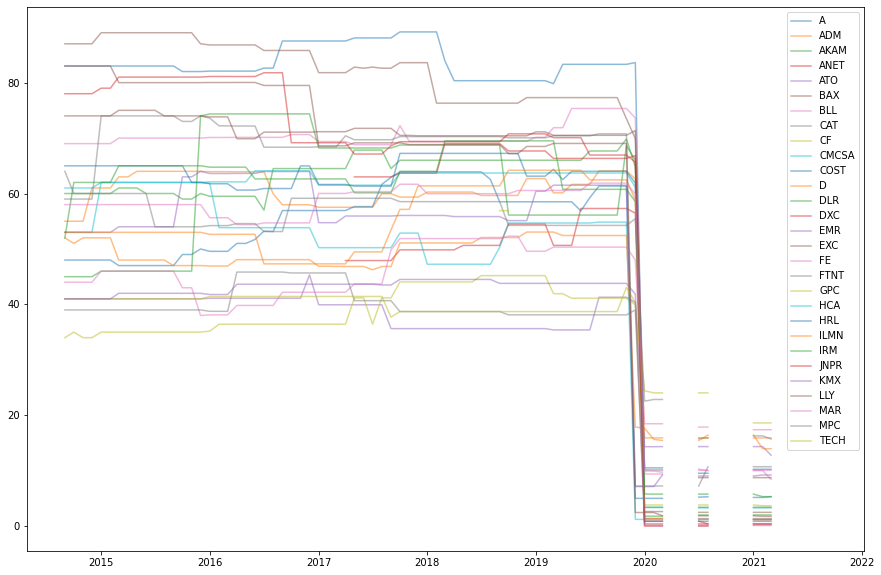

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in TICKERS[::10]:
    tmp = ESG_data.loc[ESG_data['ticker'] == ticker].sort_values(by = 'timestamp')
    out = plt.plot(tmp['timestamp'], tmp['environmentScore'], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

There is a clear structural break.

## Price and ESG dataframe

In [8]:
esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = np.min(ESG_data['timestamp'])
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series

2014-09-01 00:00:00
2021-09-01 00:00:00


Unnamed: 0  timestamp  esgScore  governanceScore  environmentScore  \
0               0 2014-09-01     73.00            73.00             73.00   
1               1 2014-10-01     72.00            73.00             72.00   
2               2 2014-11-01     73.00            73.00             73.00   
3               3 2014-12-01     73.00            73.00             73.00   
4               4 2015-01-01     74.00            78.00             70.00   
...           ...        ...       ...              ...               ...   
22934          80 2021-05-01     22.98            10.78              0.90   
22935          81 2021-06-01       NaN              NaN               NaN   
22936          82 2021-07-01       NaN              NaN               NaN   
22937          83 2021-08-01       NaN              NaN               NaN   
22938          84 2021-09-01     22.39            10.42              0.79   

       socialScore ticker        date  
0            74.00    MMM  2014-09-01  
1            74.00    MMM  2014-10-01  
2            74.00    MMM  2014-11-01  
3            74.00    MMM  2014-12-01  
4            76.00    MMM  2015-01-01  
...            ...    ...         ...  
22934        11.31    MRK  2021-05-01  
22935          NaN    MRK  2021-06-01  
22936          NaN    MRK  2021-07-01  
22937          NaN    MRK  2021-08-01  
22938        11.18    MRK  2021-09-01  

[22939 rows x 8 columns]

In [9]:
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] >= min_date, price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values (the first row)
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')

In [10]:
# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot


A    AAL    AAP   AAPL   ABBV   ABC    ABT    ACN   ADBE  \
date                                                                       
2014-09-01  73.00  73.00  48.00  61.00  64.00  55.0  64.00  72.00  70.00   
2014-09-02    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2014-09-03    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2014-09-04    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2014-09-05    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...   ...    ...    ...    ...   
2021-08-28    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2021-08-29    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2021-08-30    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2021-08-31    NaN    NaN    NaN    NaN    NaN   NaN    NaN    NaN    NaN   
2021-09-01  16.57  29.81  12.58  16.92  27.38  13.0  25.96  11.41  10.78   

              ADI  ...    MTB  PEAK     RE   SCHW    SJM   STZ      T  TECH  \
date               ...                                                        
2014-09-01  66.00  ...  50.00   NaN  45.00  50.00  61.00  54.0  66.00   NaN   
2014-09-02    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2014-09-03    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2014-09-04    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2014-09-05    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
...           ...  ...    ...   ...    ...    ...    ...   ...    ...   ...   
2021-08-28    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2021-08-29    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2021-08-30    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2021-08-31    NaN  ...    NaN   NaN    NaN    NaN    NaN   NaN    NaN   NaN   
2021-09-01  23.82  ...  27.23  10.8  18.16  24.41  26.64   NaN  19.13   NaN   

              XOM   XRAY  
date                      
2014-09-01  66.00  57.00  
2014-09-02    NaN    NaN  
2014-09-03    NaN    NaN  
2014-09-04    NaN    NaN  
2014-09-05    NaN    NaN  
...           ...    ...  
2021-08-28    NaN    NaN  
2021-08-29    NaN    NaN  
2021-08-30    NaN    NaN  
2021-08-31    NaN    NaN  
2021-09-01  35.77  20.07  

[2558 rows x 283 columns]

In [13]:
# Create dictionary to store which company belongs to which sector
sector_classification = dict()
for i in range(asset_profiles.shape[0]):
    if asset_profiles['sector'].iloc[i] not in sector_classification.keys():
        sector_classification[asset_profiles['sector'].iloc[i]] = list()
    sector_classification[asset_profiles['sector'].iloc[i]].append(asset_profiles['ticker'].iloc[i])

## Group membership vocab

In [11]:
group_membership_sector = Gibbs.group_membering(asset_profiles, 'sector')
group_membership_industry = Gibbs.group_membering(asset_profiles, 'industry')


# Plot sectors

Too see if there is a clear trend.

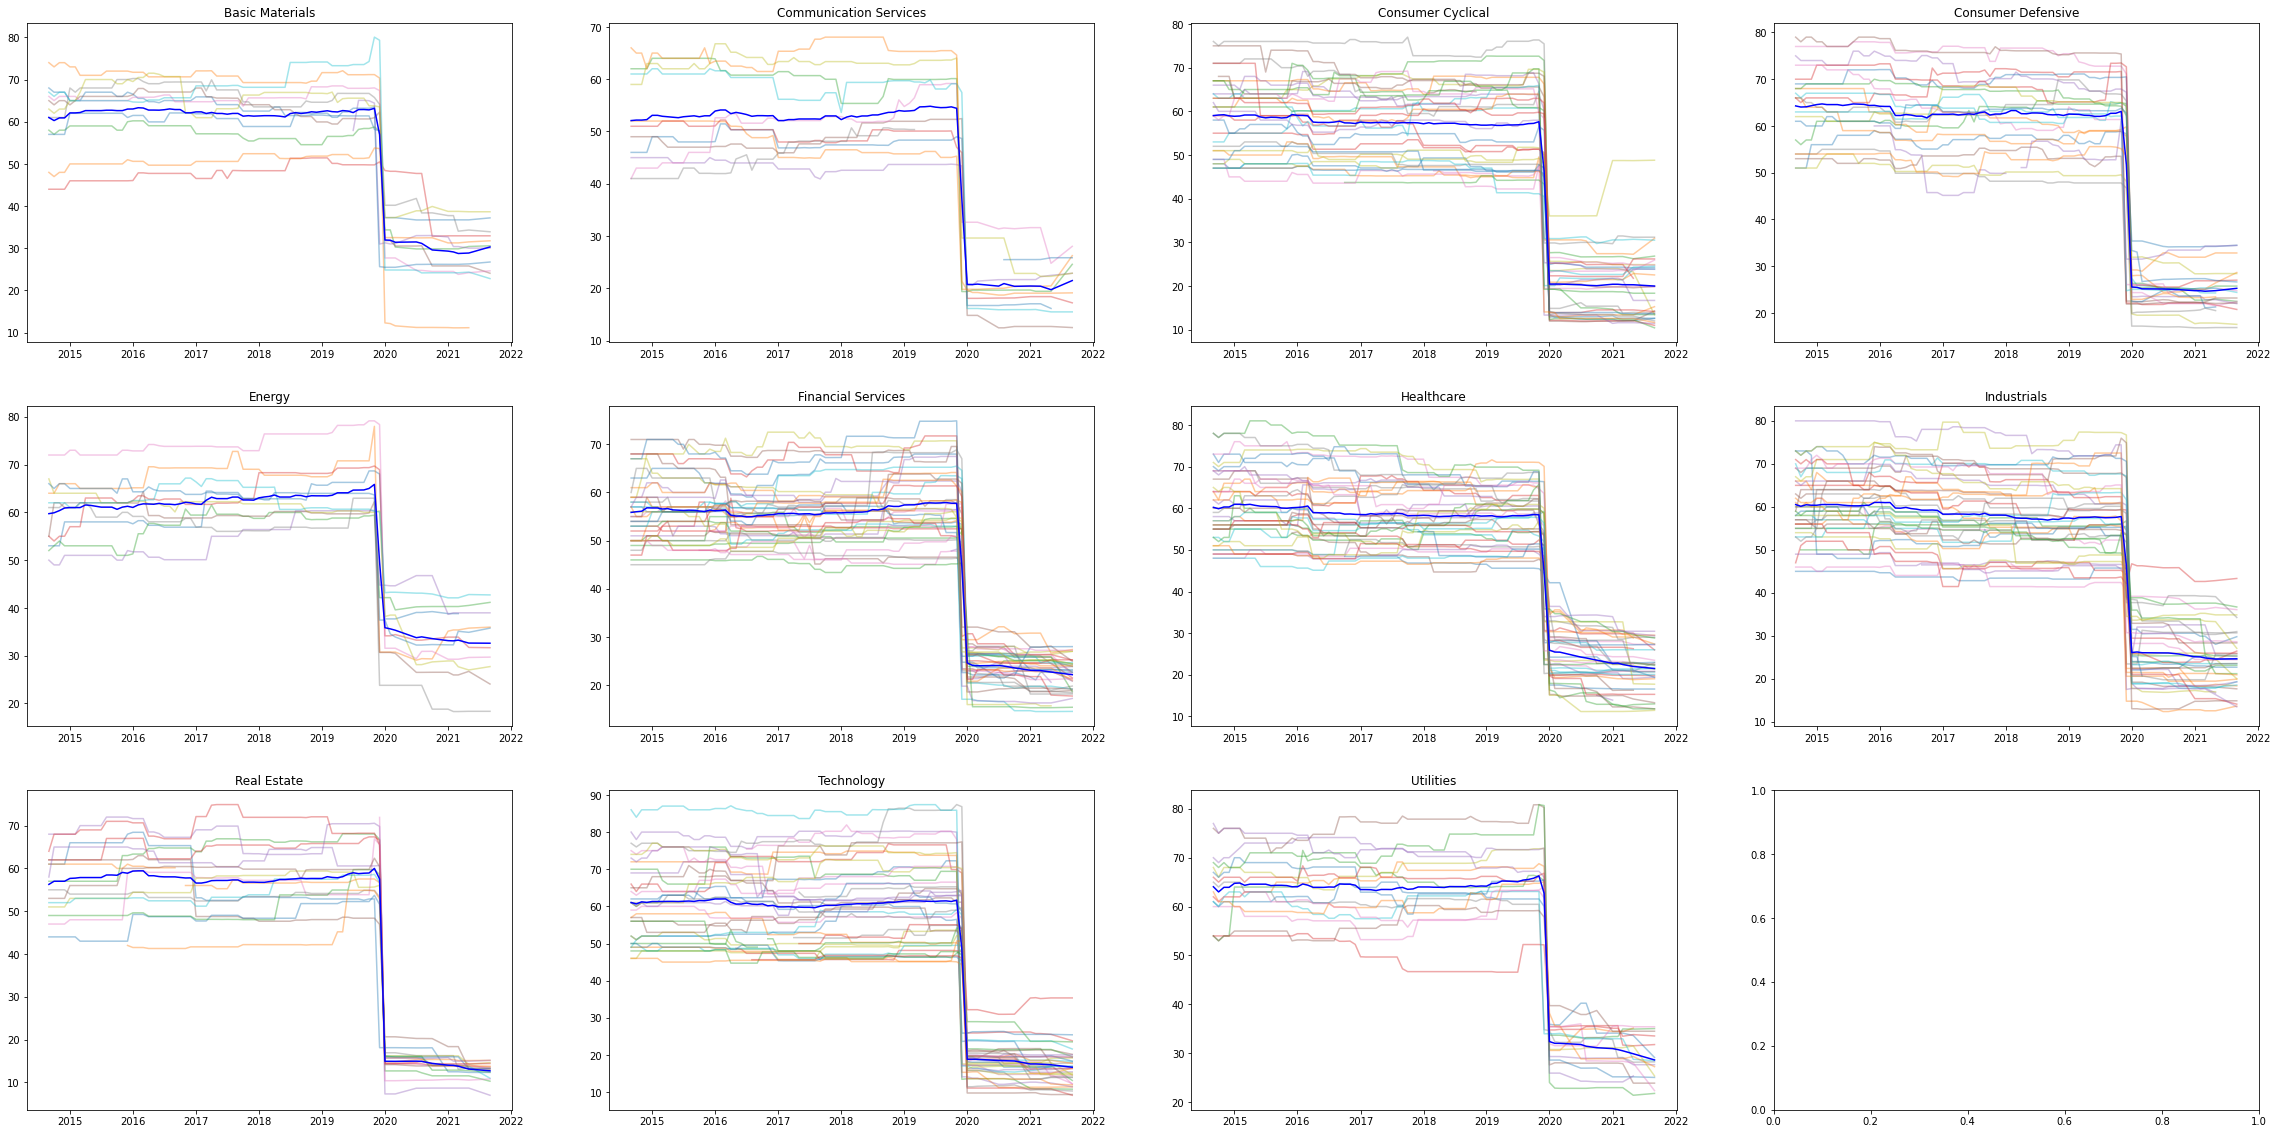

In [10]:

fig, axs = plt.subplots( 3, 4, figsize = (40,20))
    
tmp = esg_pivot.dropna(axis = 0, how = 'all' )

for idx, sector in enumerate(group_membership_sector.keys()):

    j = idx % 4
    i = int(np.floor(idx/4)) 
    
    companies_in_sector = asset_profiles['ticker'].loc[asset_profiles['sector'] == sector]
    avg = np.nanmean(tmp.loc[:, tmp.columns.isin(companies_in_sector)], axis = 1)
    axs[i,j].plot(tmp.index, tmp.loc[:, tmp.columns.isin(companies_in_sector)], alpha = 0.4)
    axs[i,j].plot(tmp.index, avg, color = 'blue')
    axs[i,j].set_title(sector)

Let's break each sector down to its industries

In [11]:
def plot_esg_industry(sector, asset_profiles, esg_data):
    industries = np.unique(asset_profiles['industry'].loc[asset_profiles['sector'] == sector])

    k = len(industries)

    fig, axs = plt.subplots( int(k/4)+1 , 4, figsize = (40 ,5*(int(k/4)+1)))
        

    for idx, industry in enumerate(industries):

        j = idx % 4
        i = int(np.floor(idx/4)) 
        
        companies_in_industry = list(asset_profiles['ticker'].loc[asset_profiles['industry'] == industry])
        axs[i,j].set_title(industry)
        if np.sum(esg_data.columns.isin(companies_in_industry)) == 0:
            print(f'No esg data on companies in industry {industry}')
            continue
        companies = esg_data.loc[:, esg_data.columns.isin(companies_in_industry)]
        avg = np.nanmean(companies, axis = 1)
        axs[i,j].plot(esg_data.index, companies, alpha = 0.4)
        axs[i,j].plot(esg_data.index, avg, color = 'blue')


## Basic Materials

No esg data on companies in industry Gold
No esg data on companies in industry Steel


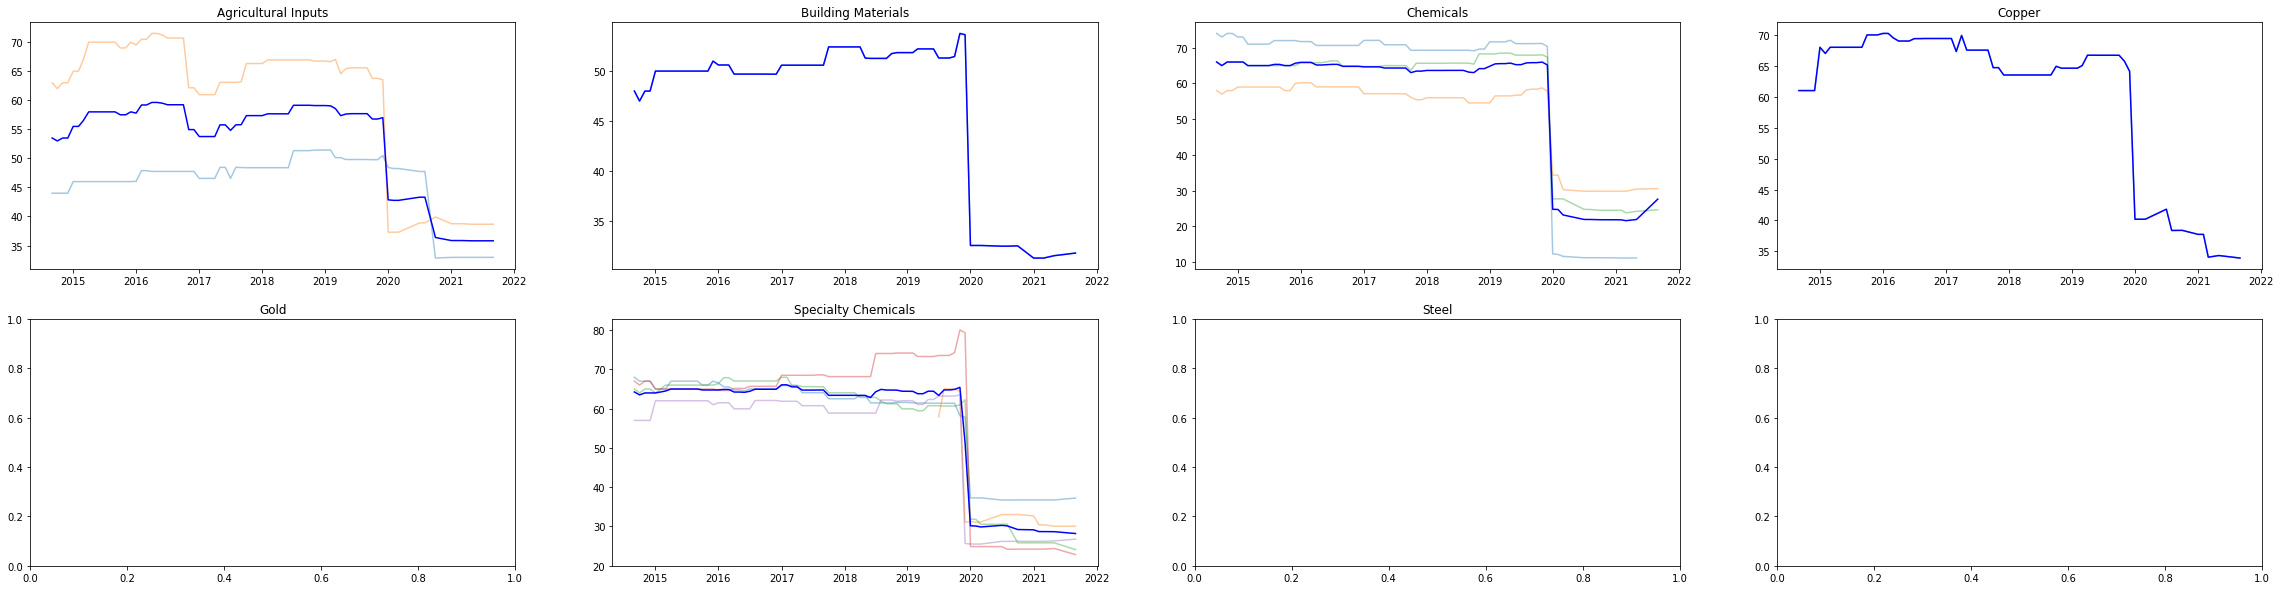

In [12]:
plot_esg_industry('Basic Materials', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Communication Services

C:\Users\ragna\AppData\Local\Temp/ipykernel_668/1048357597.py:20: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(companies, axis = 1)


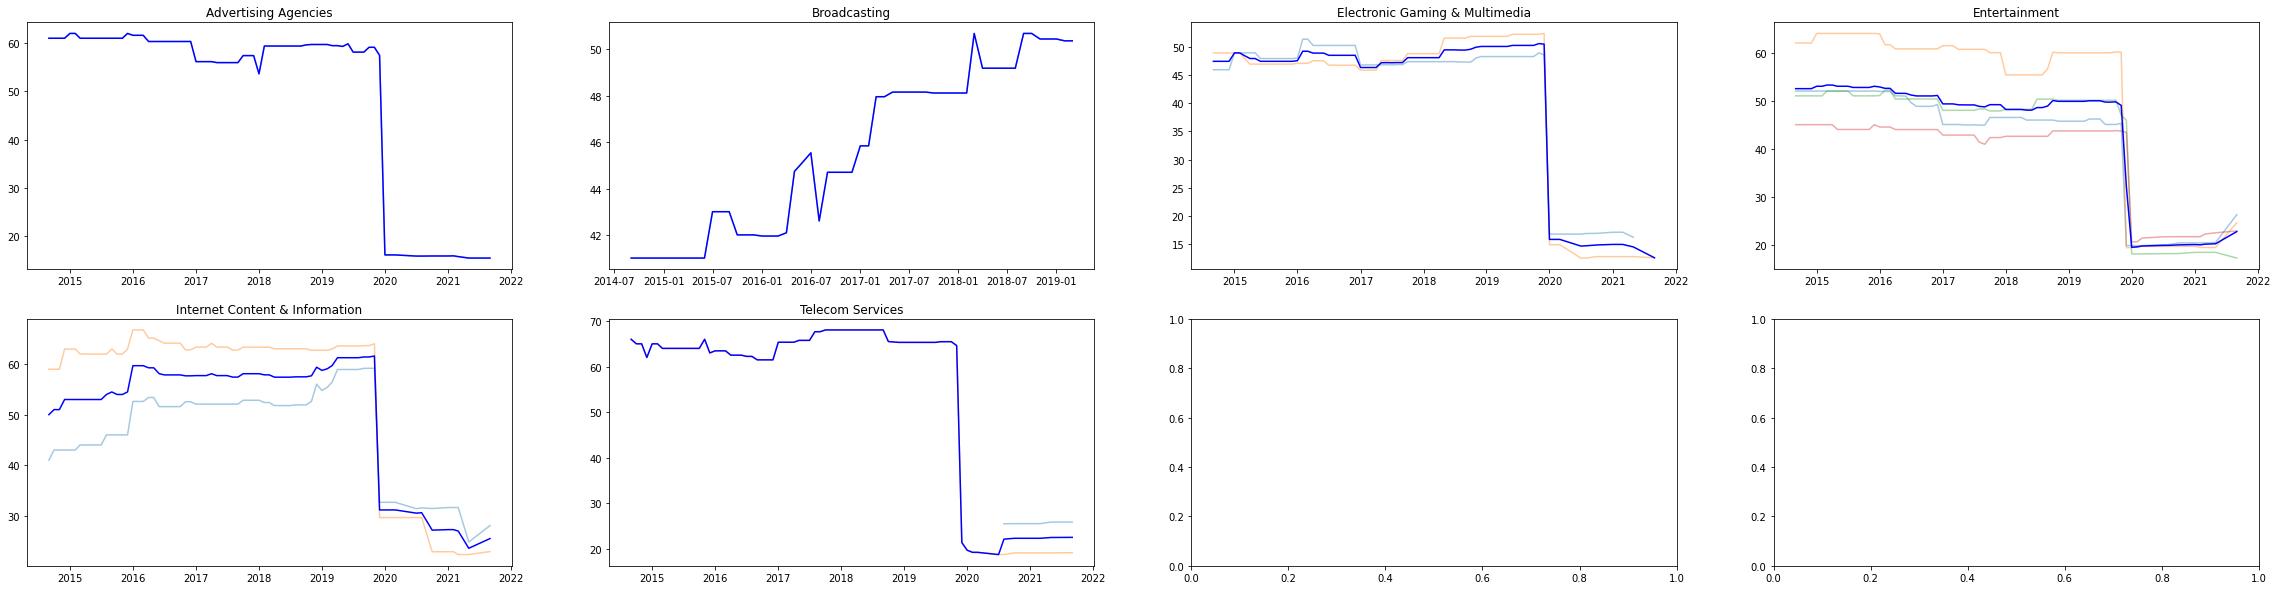

In [13]:
plot_esg_industry('Communication Services', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Consumer Cyclical

No esg data on companies in industry Footwear & Accessories
No esg data on companies in industry Luxury Goods
No esg data on companies in industry Personal Services


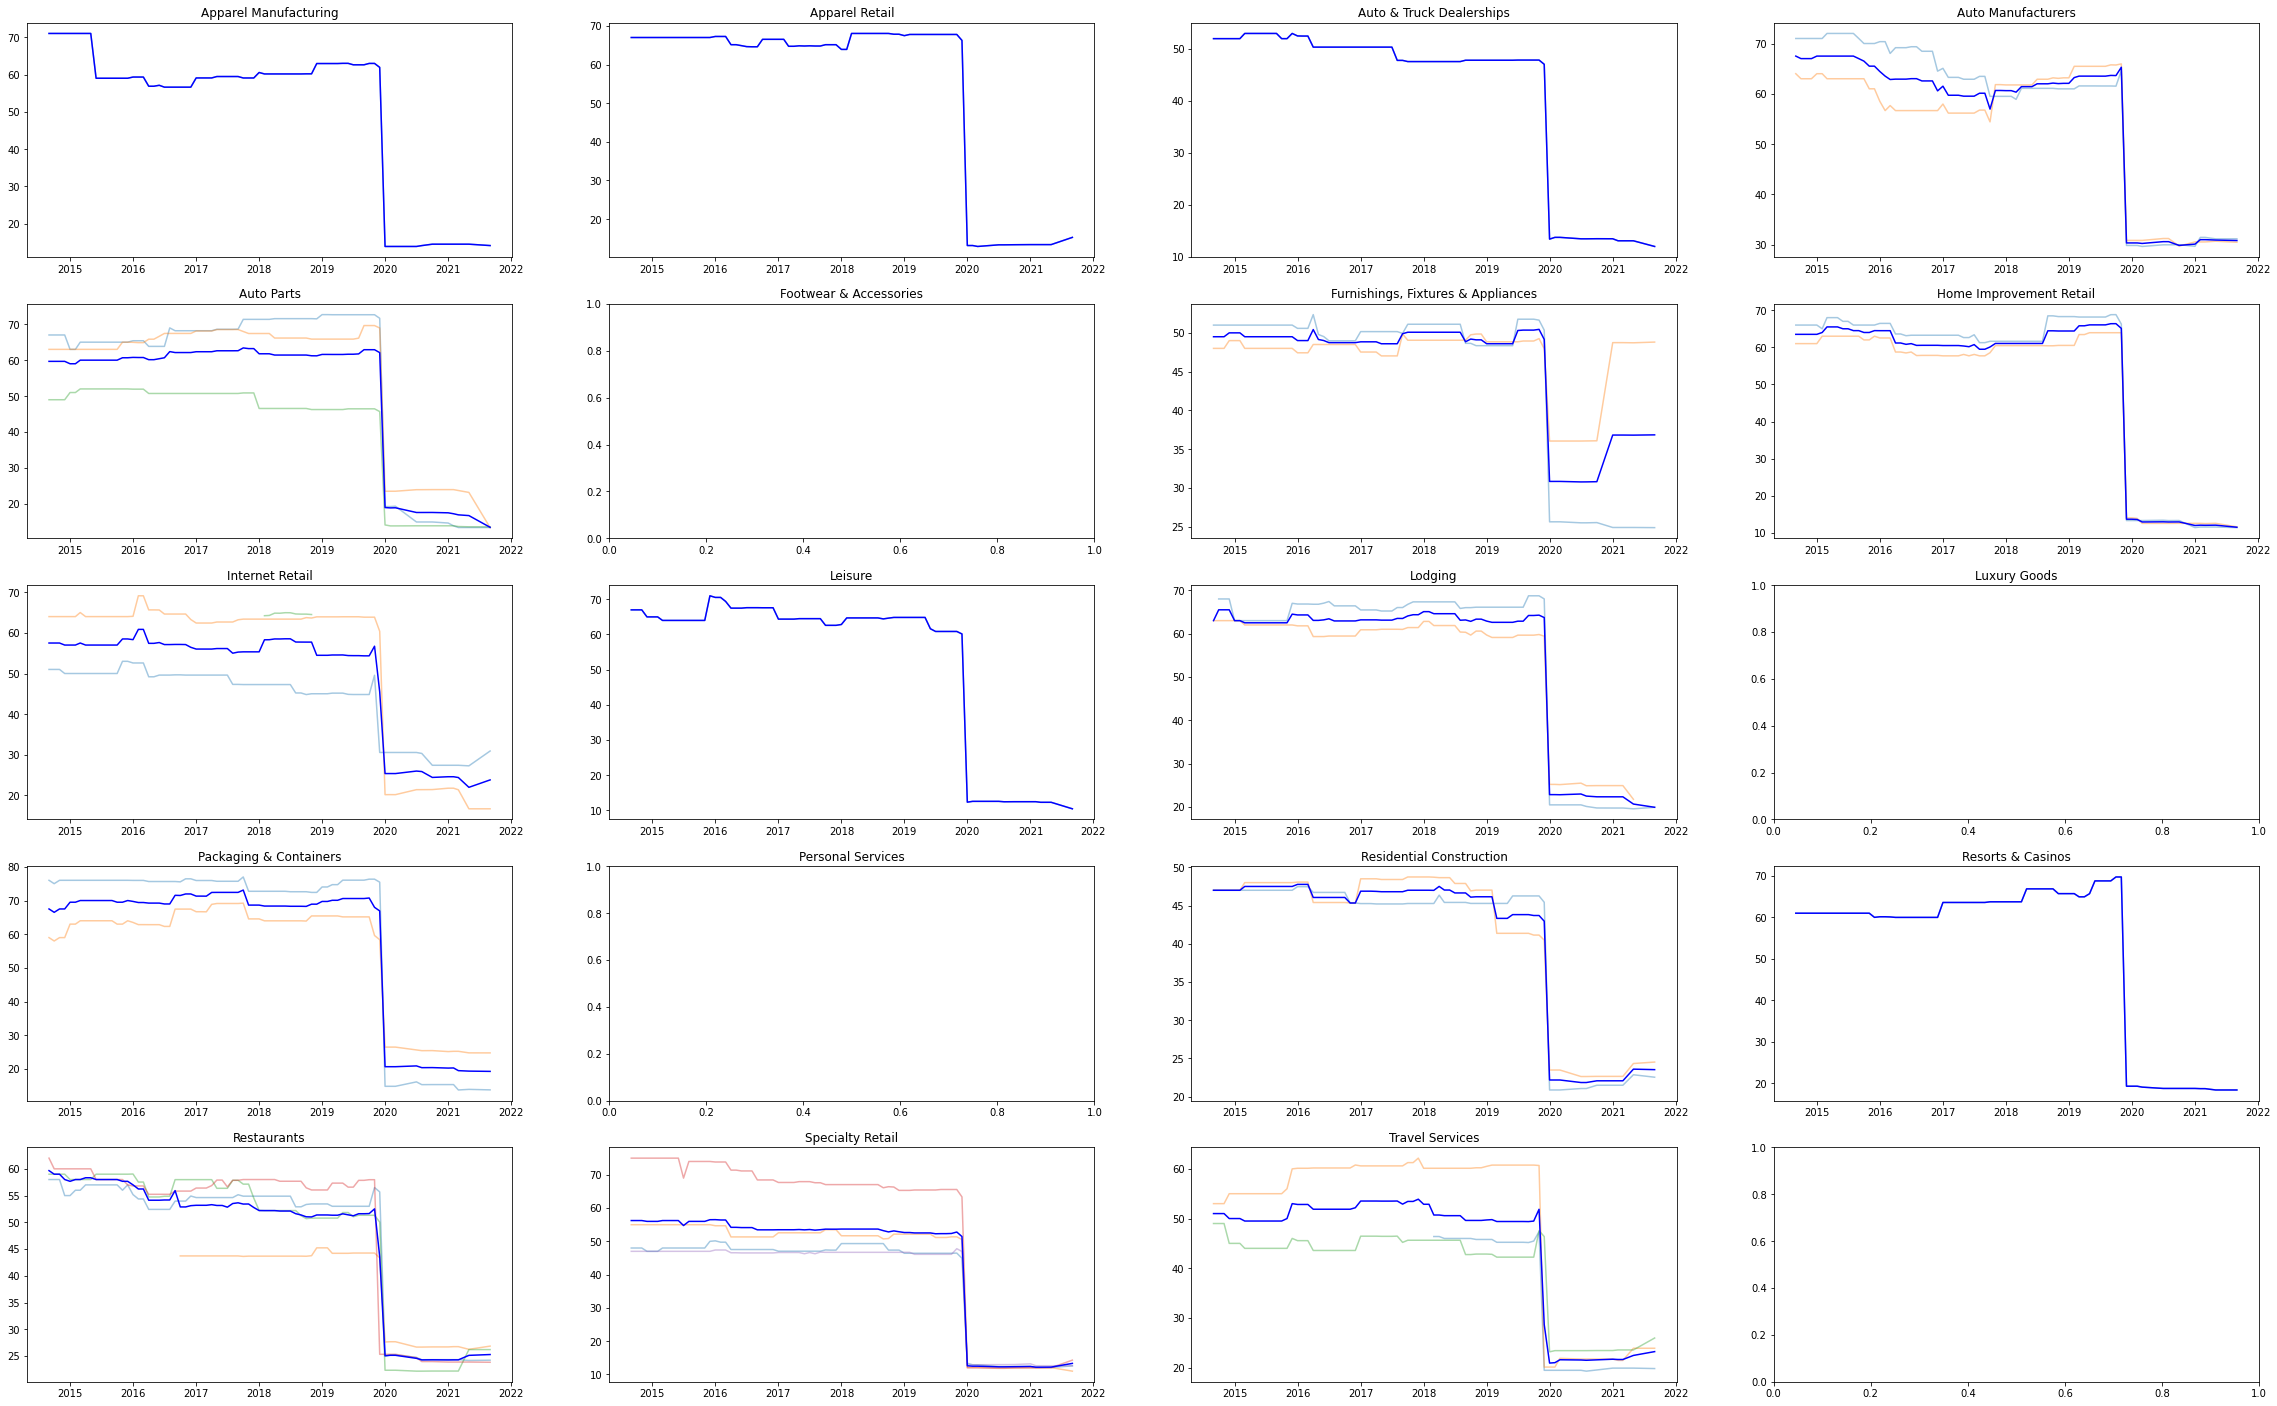

In [14]:
plot_esg_industry('Consumer Cyclical', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Consumer Defensive

No esg data on companies in industry Beverages—Brewers
No esg data on companies in industry Food Distribution


C:\Users\ragna\AppData\Local\Temp/ipykernel_668/1048357597.py:20: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(companies, axis = 1)
C:\Users\ragna\AppData\Local\Temp/ipykernel_668/1048357597.py:20: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(companies, axis = 1)


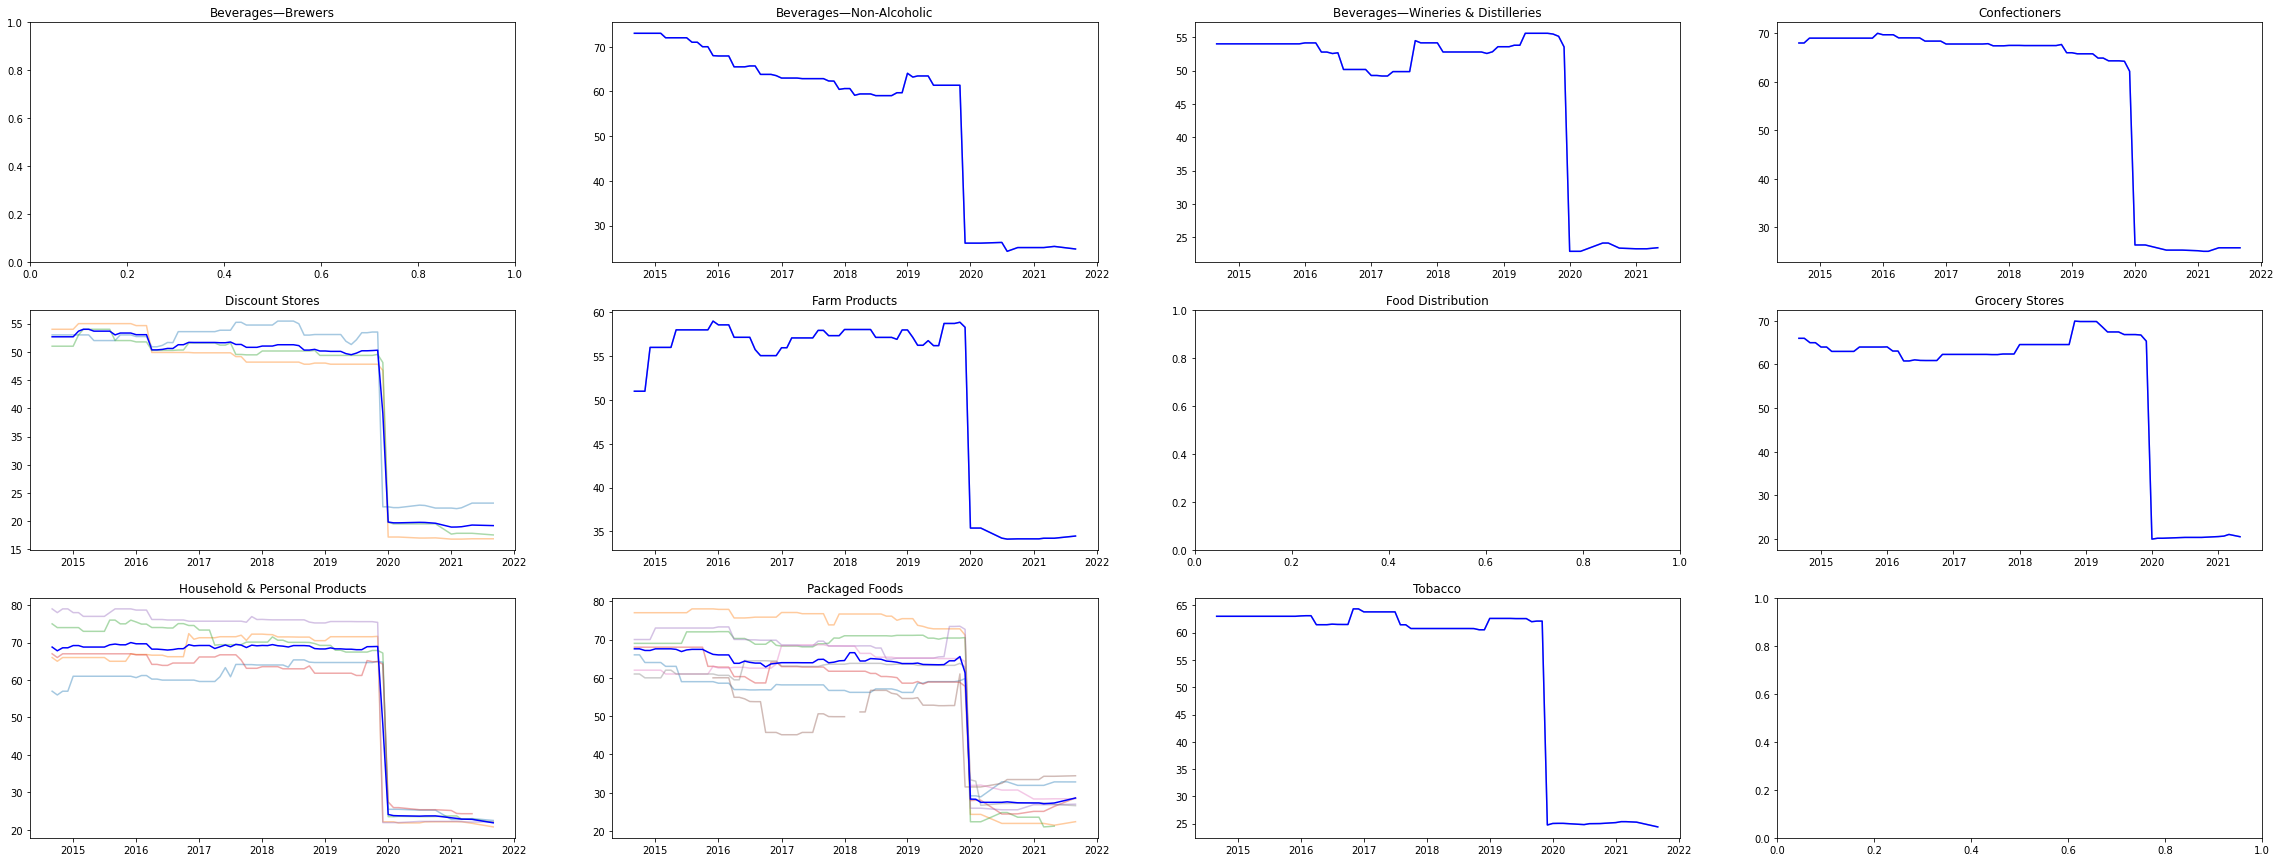

In [15]:
plot_esg_industry('Consumer Defensive', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Energy

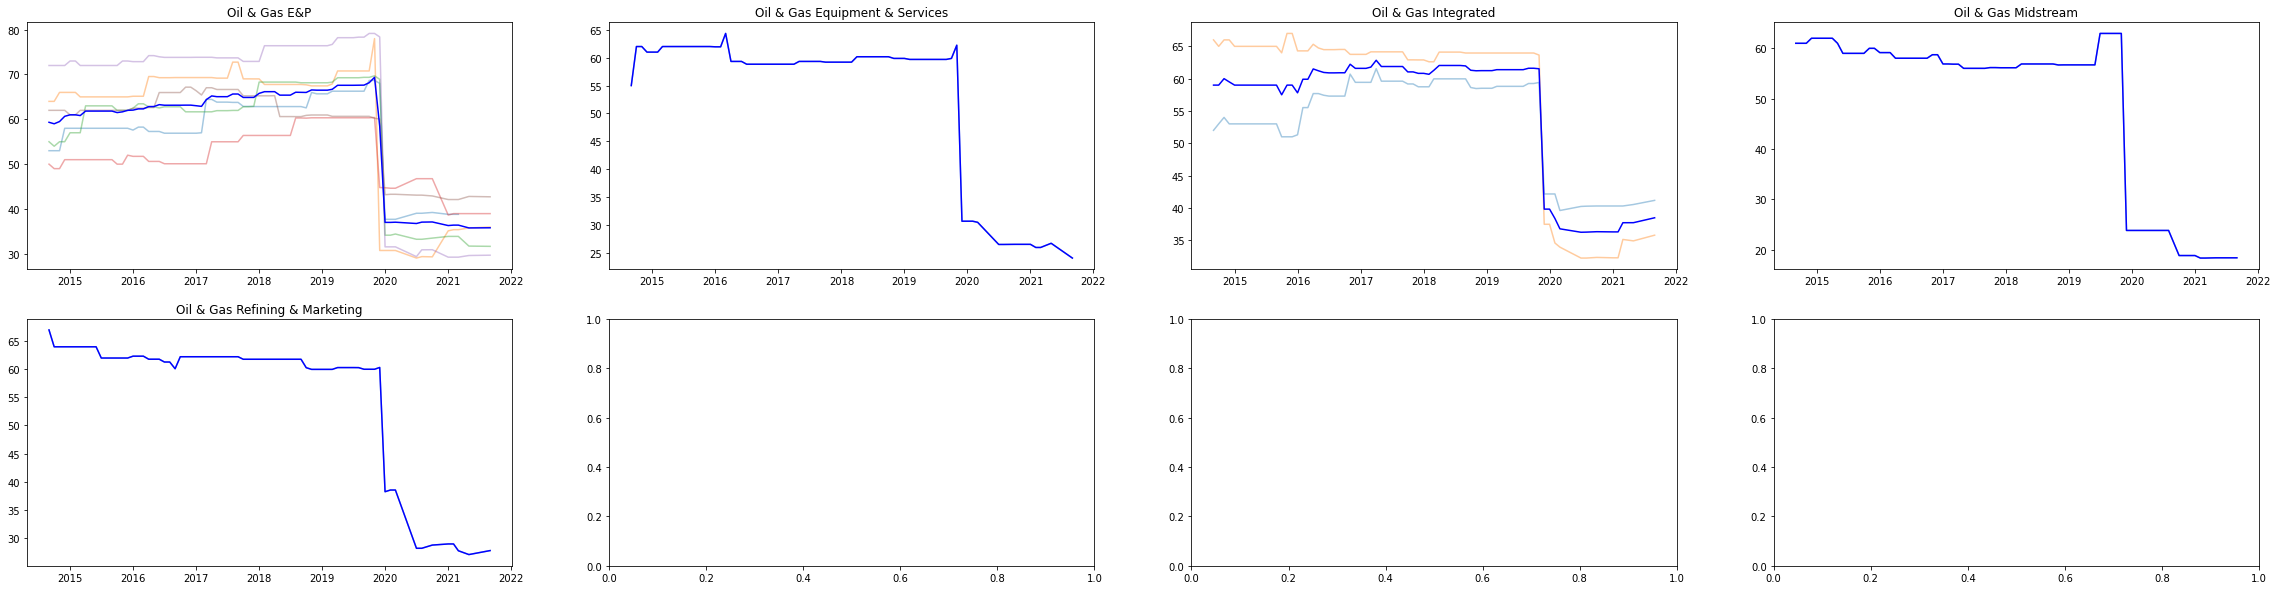

In [16]:
plot_esg_industry('Energy', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Financial Services

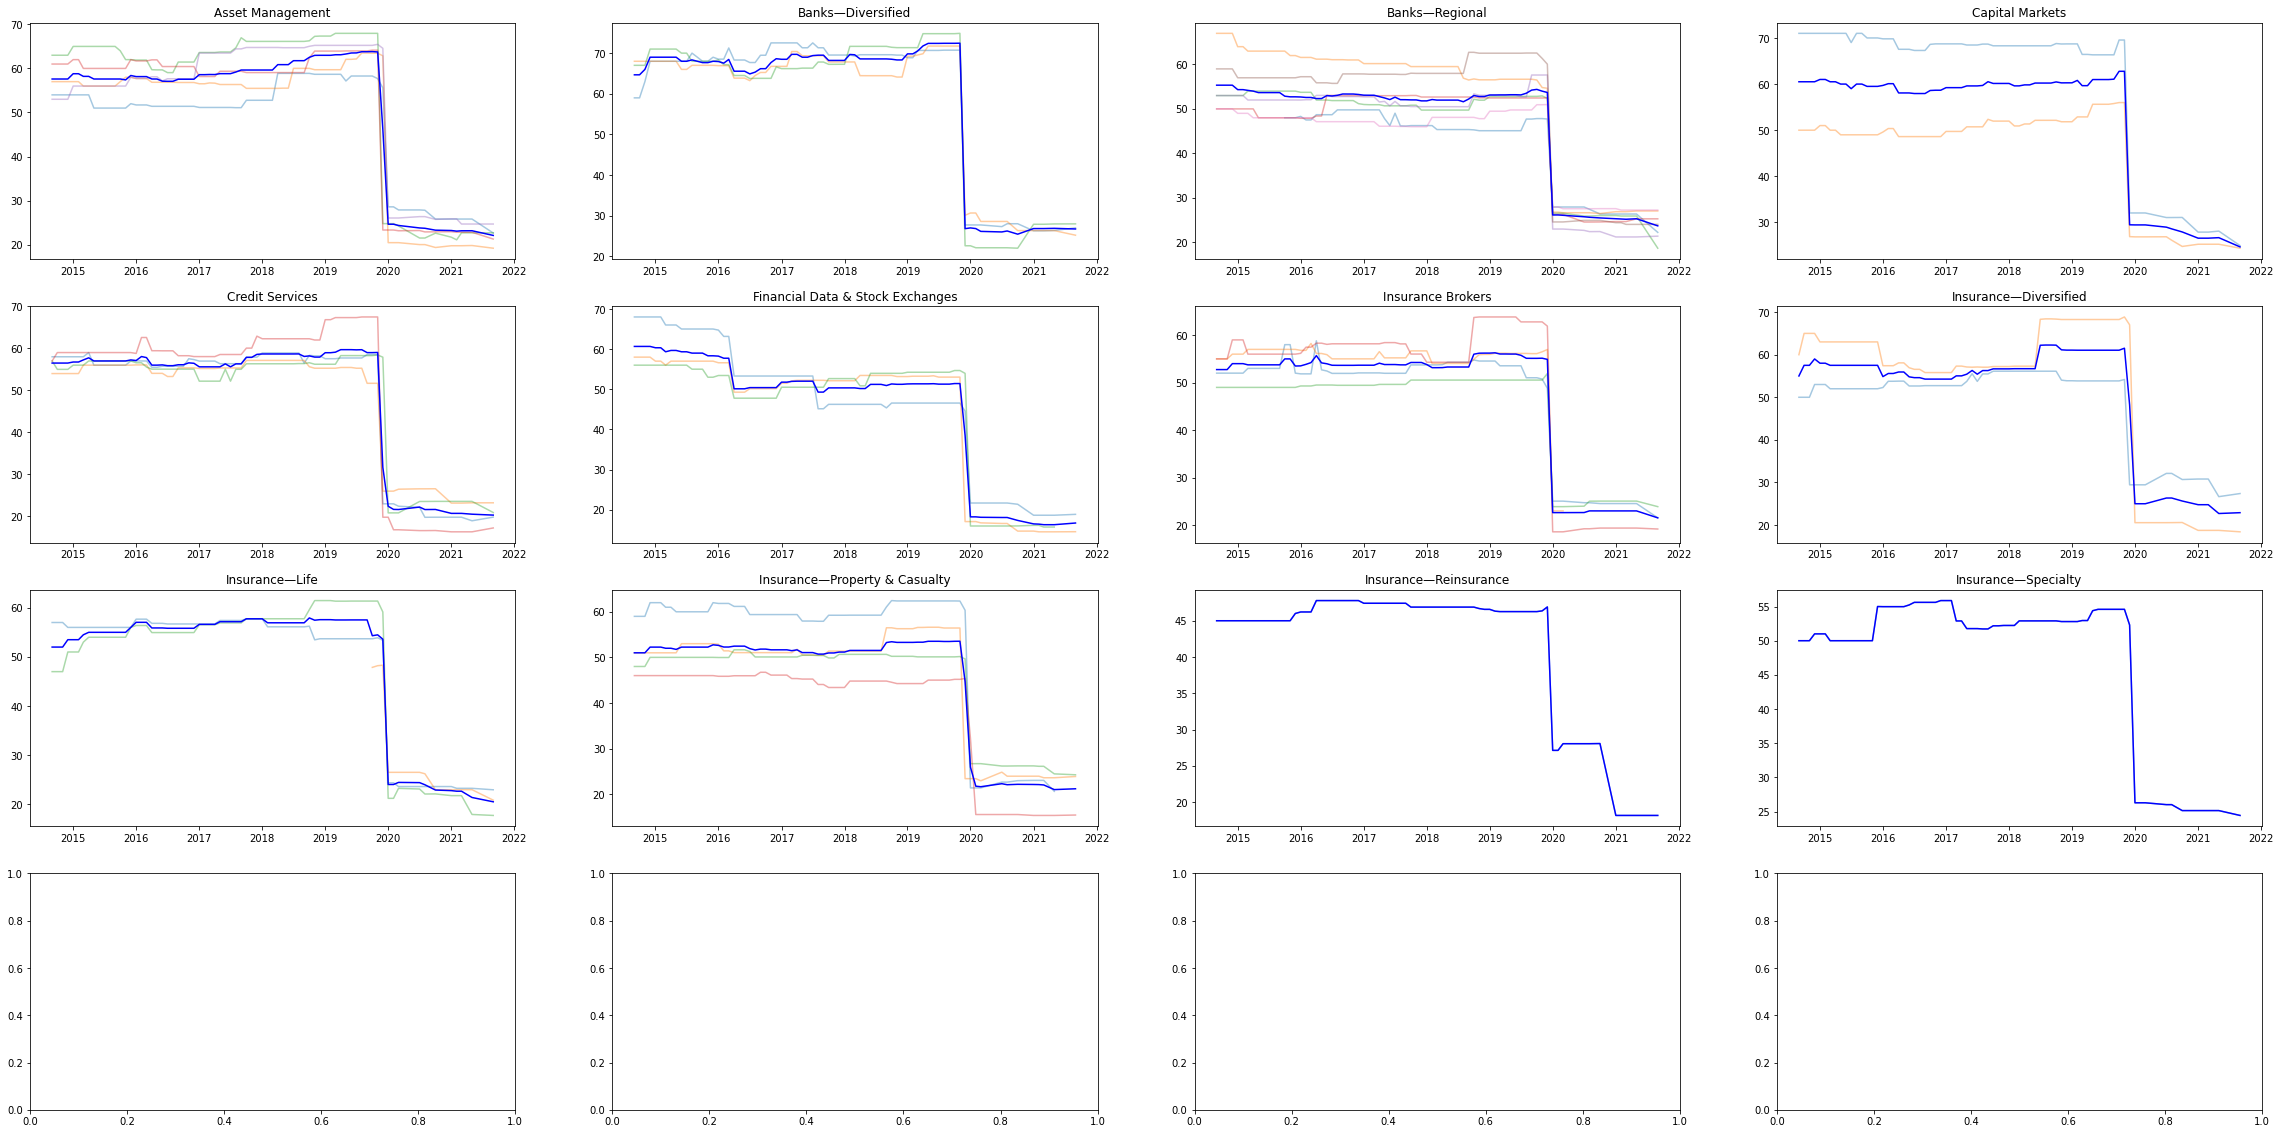

In [17]:
plot_esg_industry('Financial Services', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Healthcare

No esg data on companies in industry Drug Manufacturers—Specialty & Generic
No esg data on companies in industry Pharmaceutical Retailers


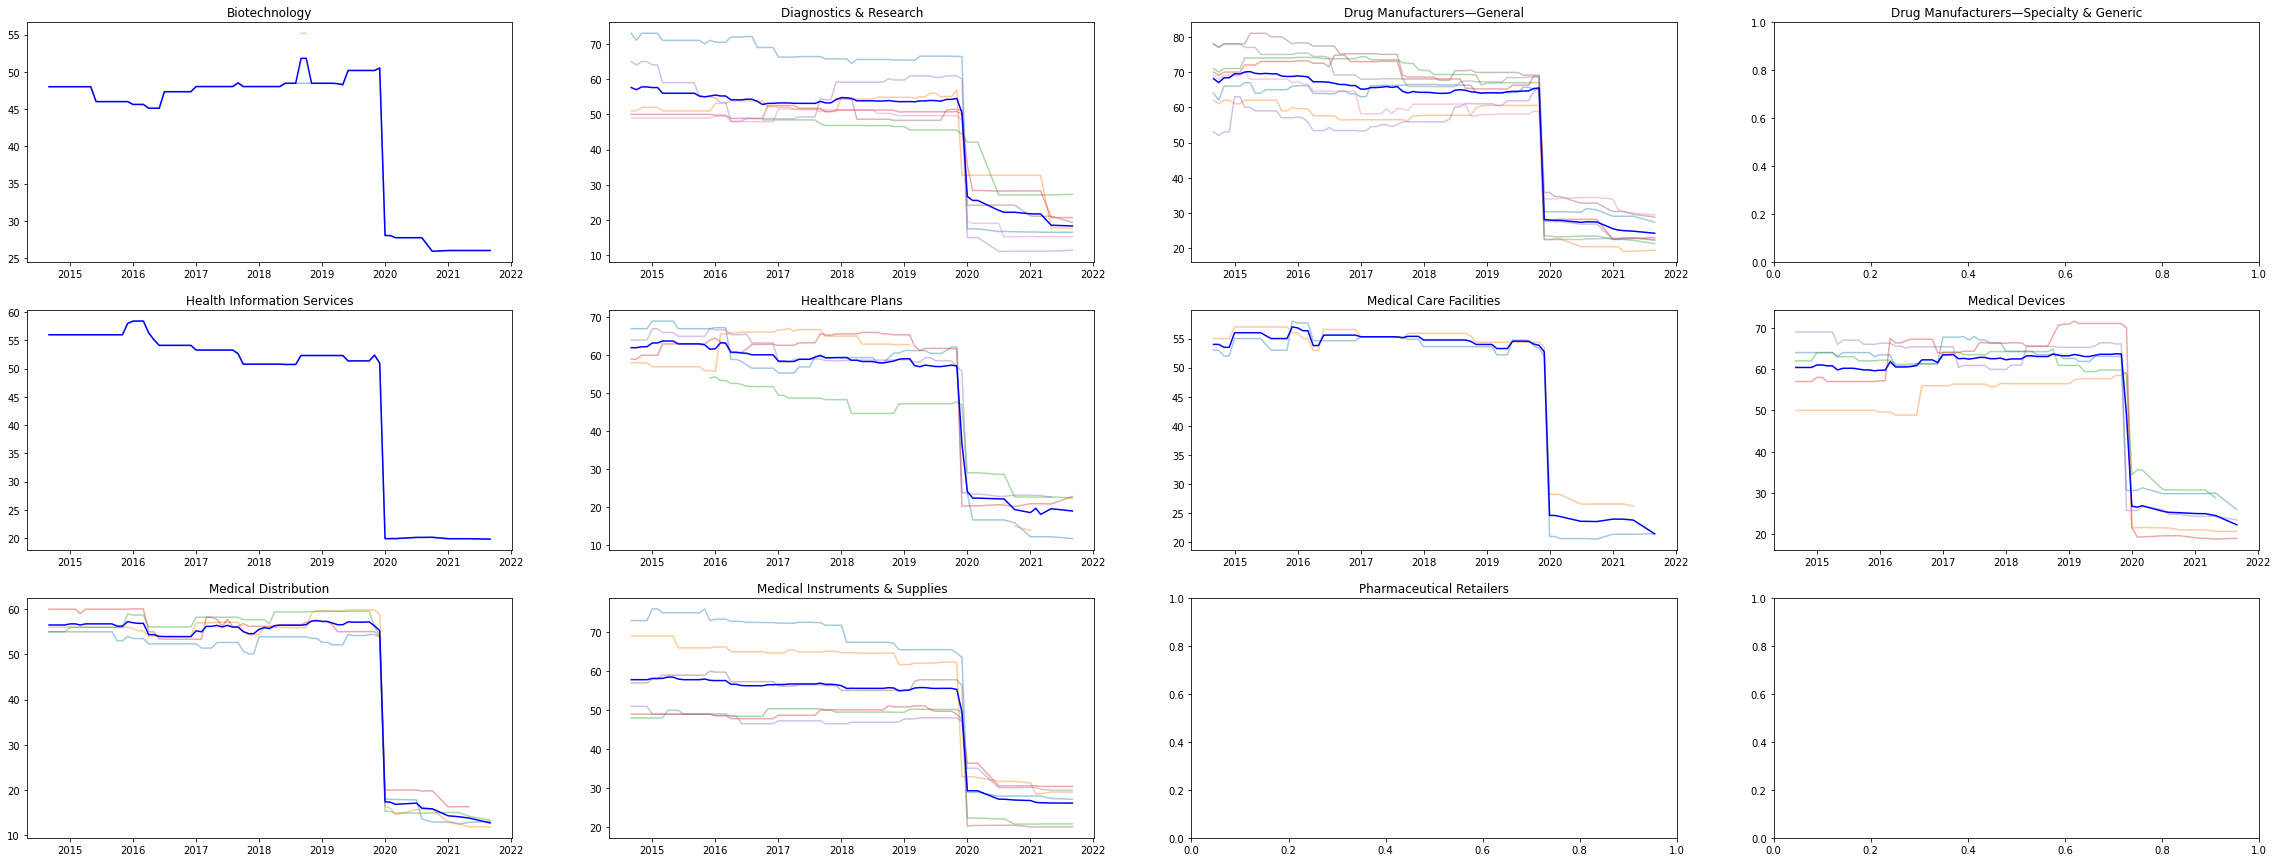

In [18]:
plot_esg_industry('Healthcare', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Industrials

No esg data on companies in industry Rental & Leasing Services
No esg data on companies in industry Tools & Accessories
No esg data on companies in industry Trucking
No esg data on companies in industry Waste Management


C:\Users\ragna\AppData\Local\Temp/ipykernel_668/1048357597.py:20: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(companies, axis = 1)


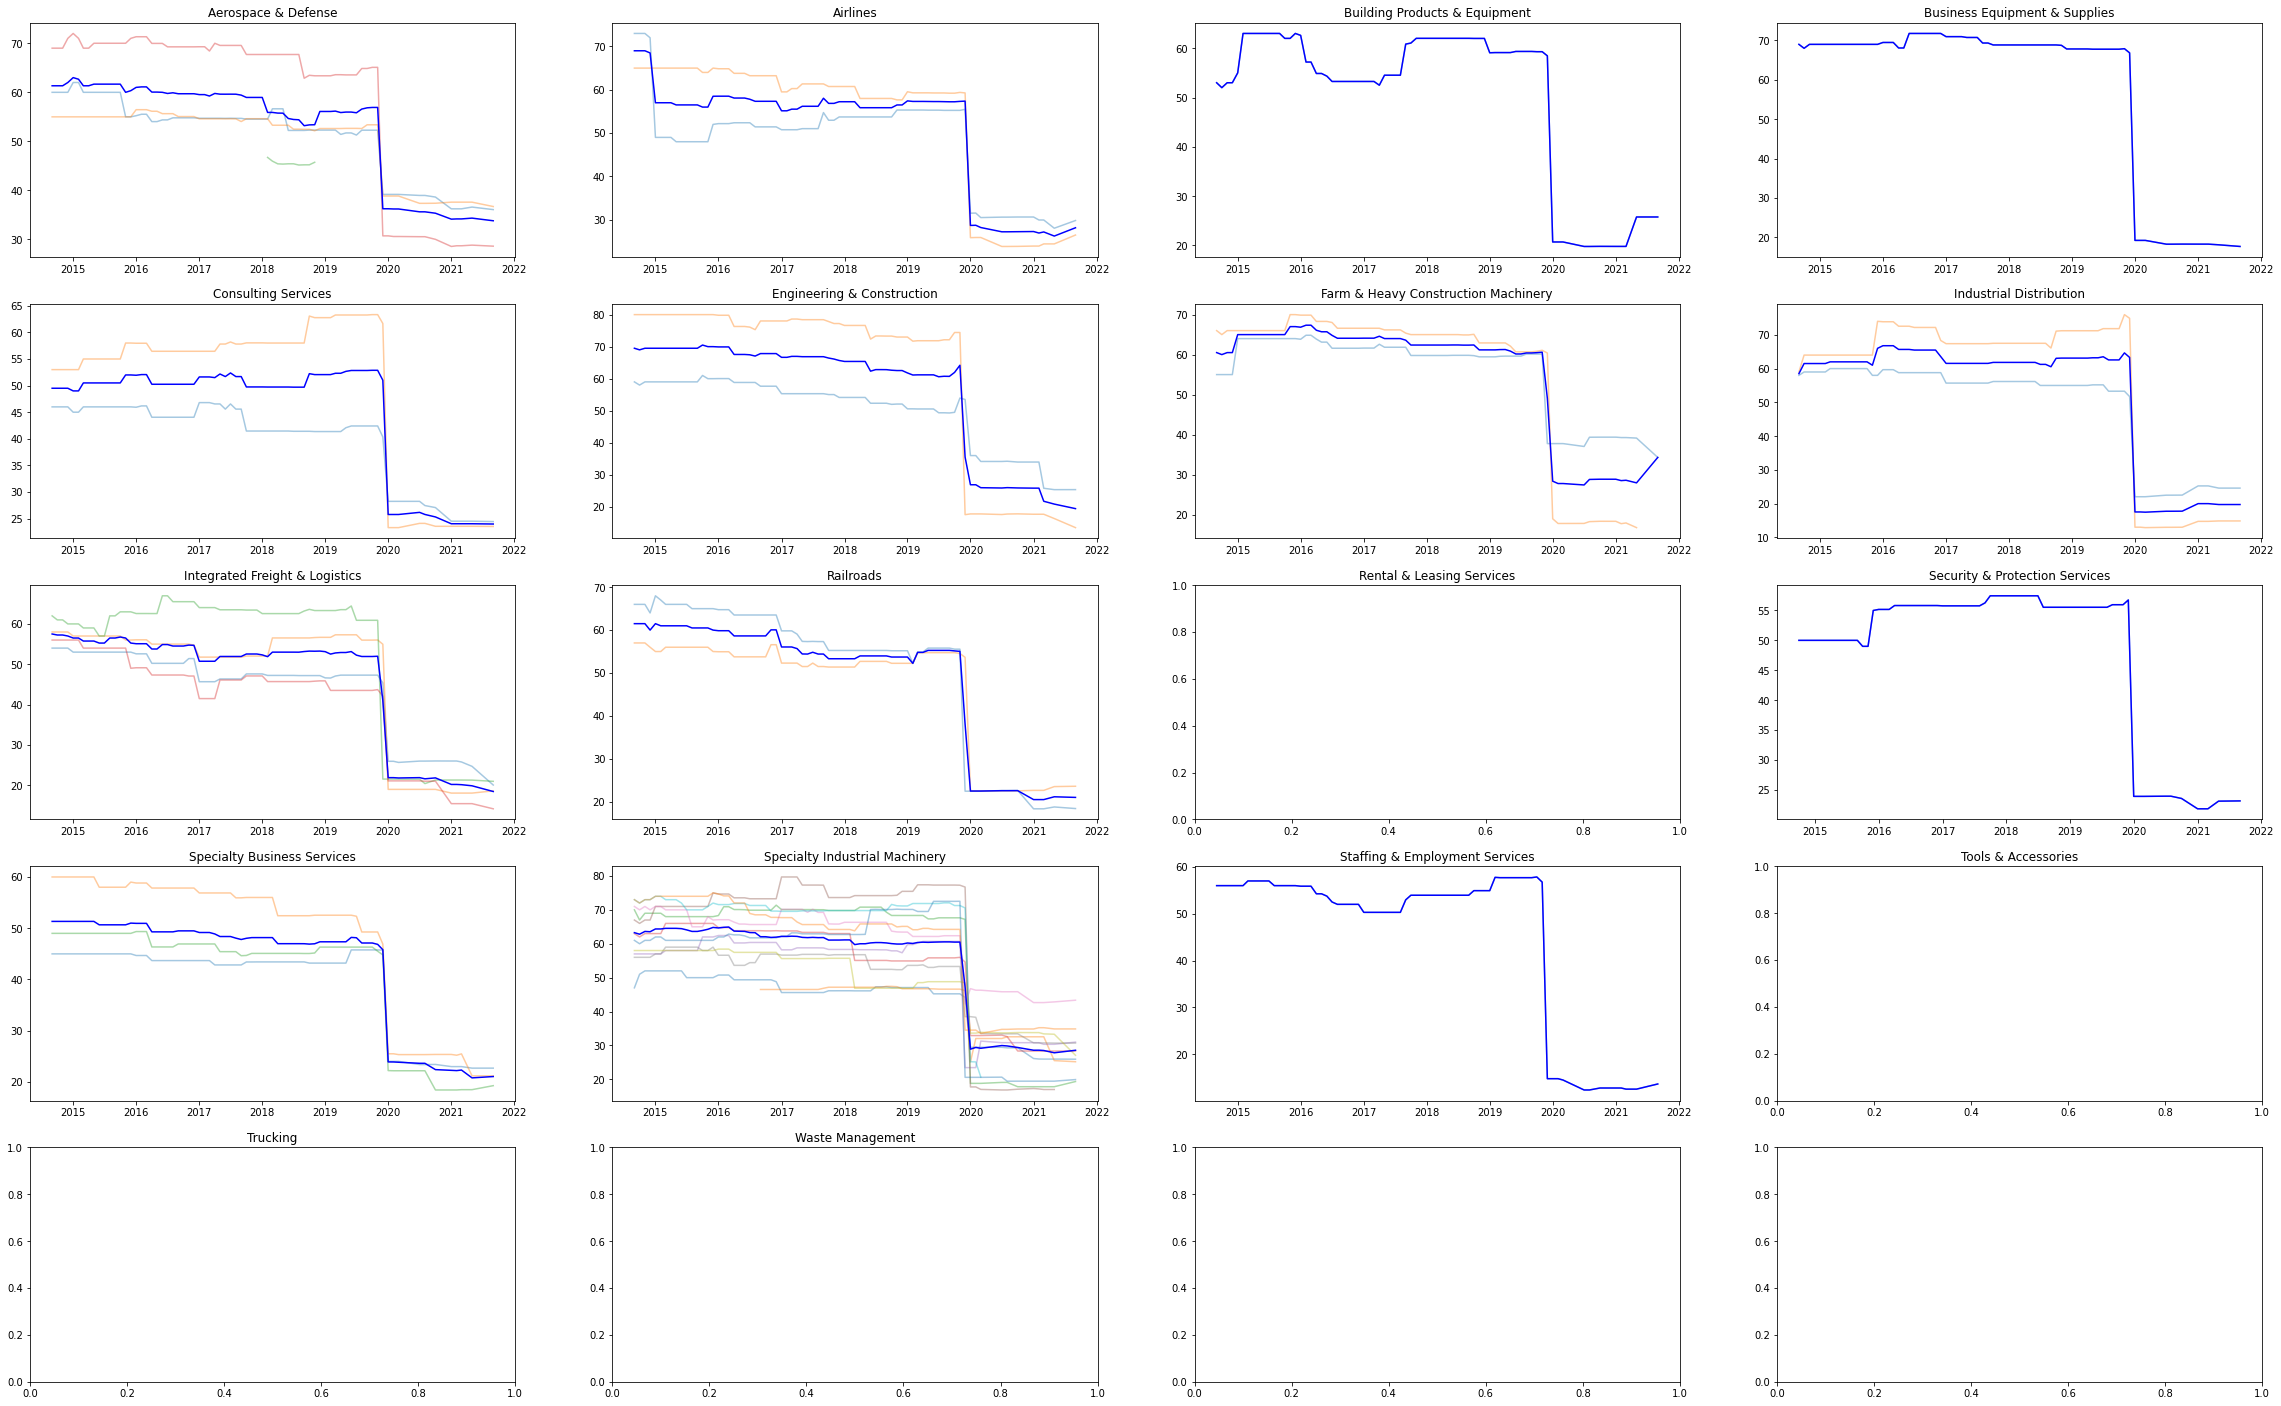

In [19]:
plot_esg_industry('Industrials', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Real Estate

C:\Users\ragna\AppData\Local\Temp/ipykernel_668/1048357597.py:20: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(companies, axis = 1)


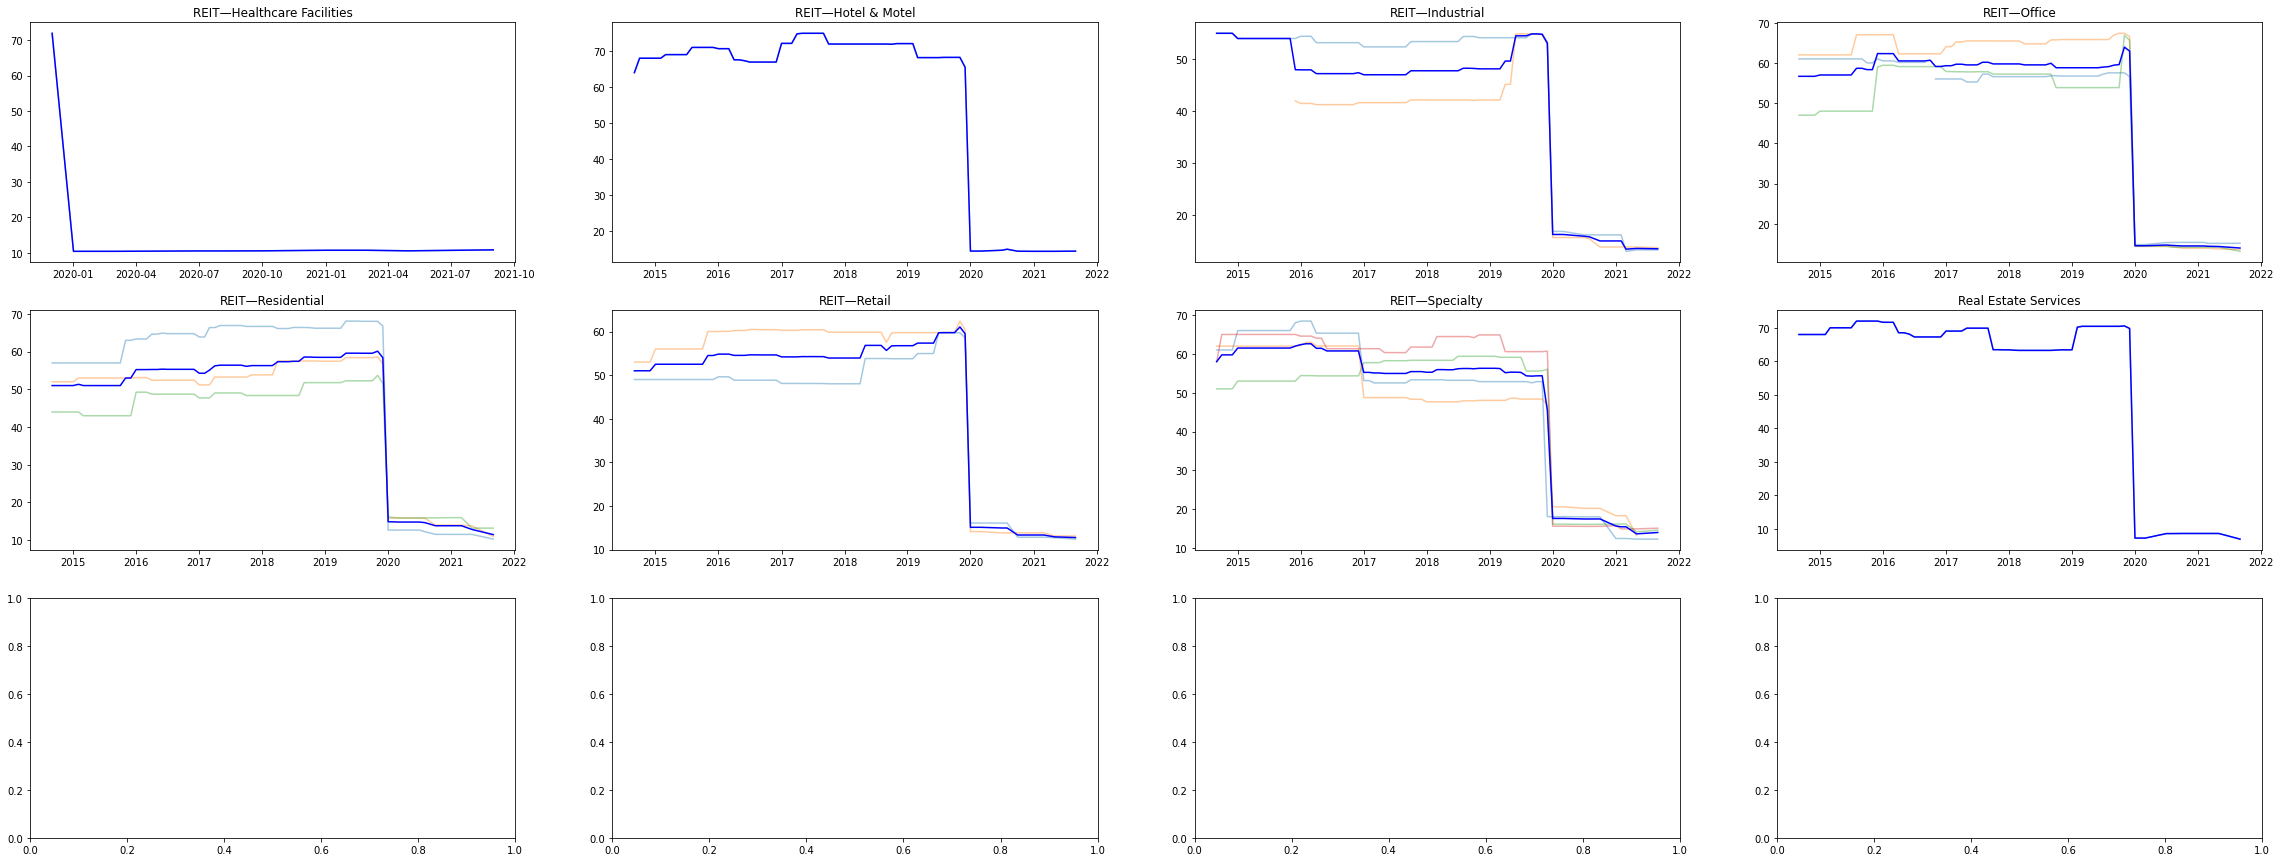

In [20]:
plot_esg_industry('Real Estate', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Technology

No esg data on companies in industry Solar


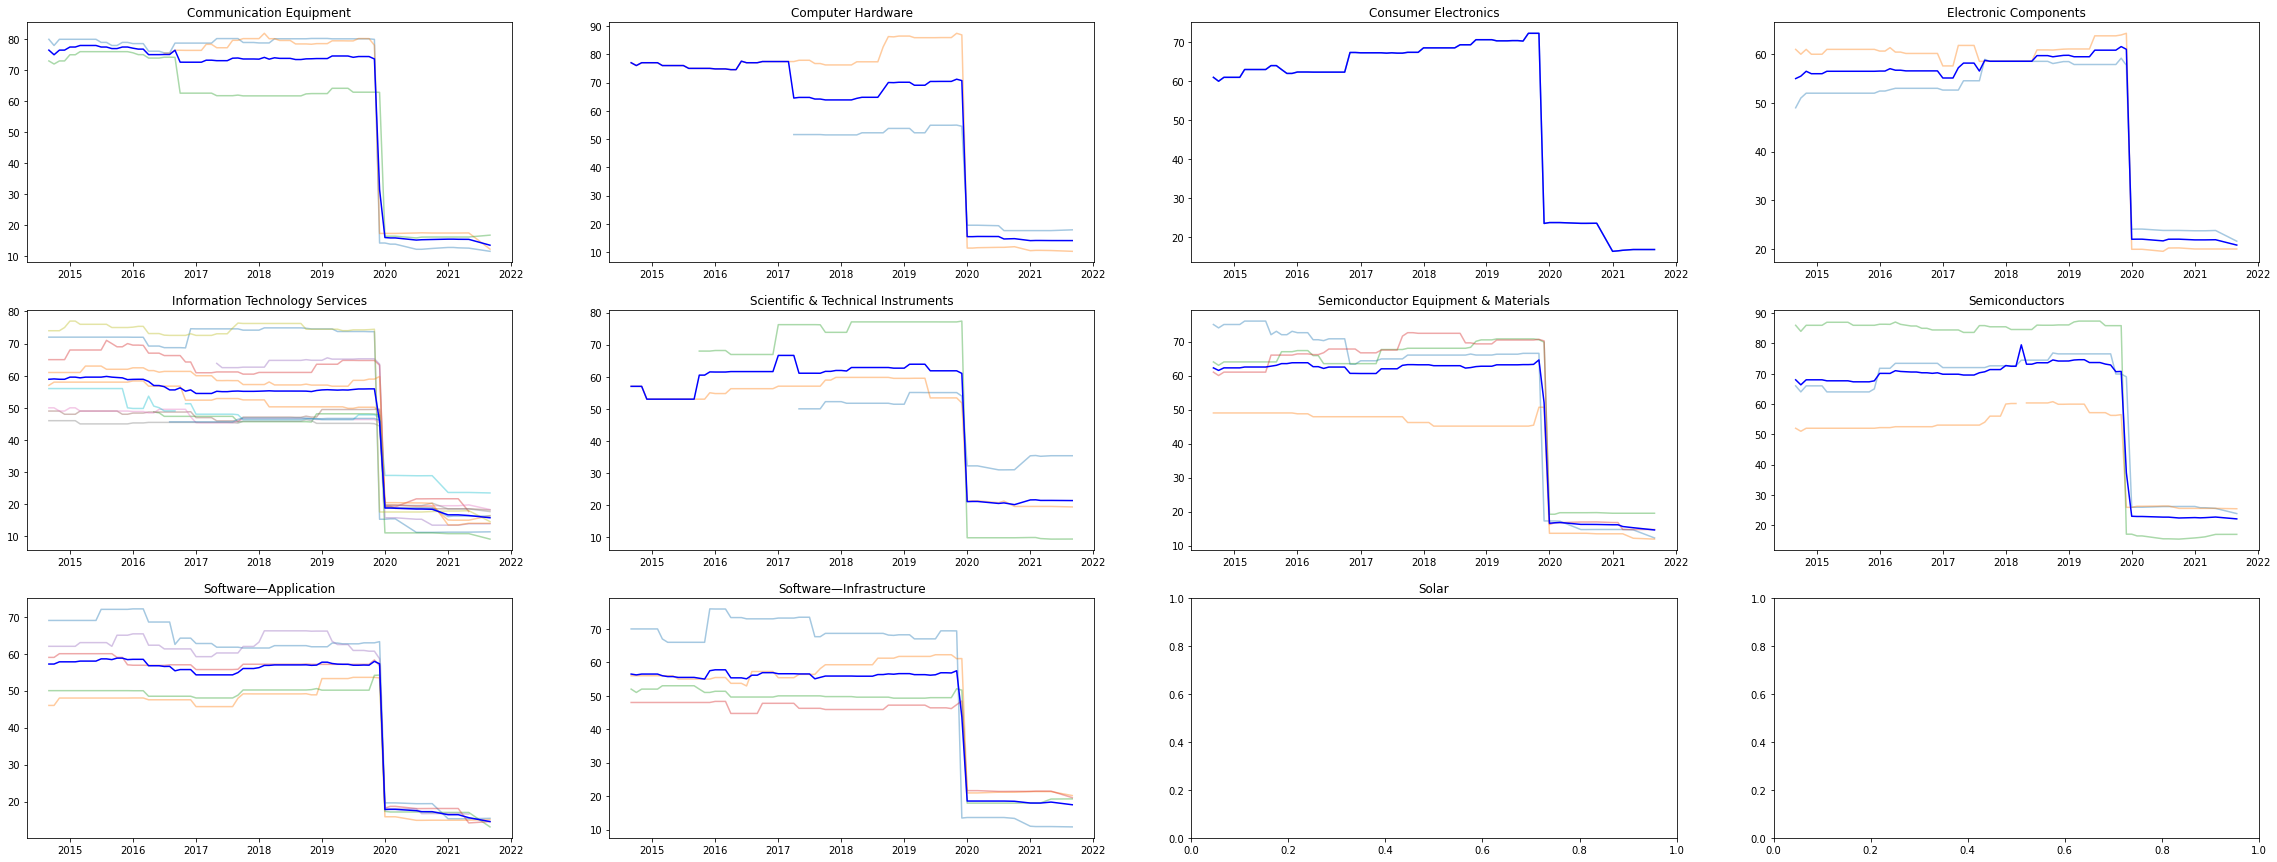

In [21]:
plot_esg_industry('Technology', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## Utilities

No esg data on companies in industry Utilities—Independent Power Producers


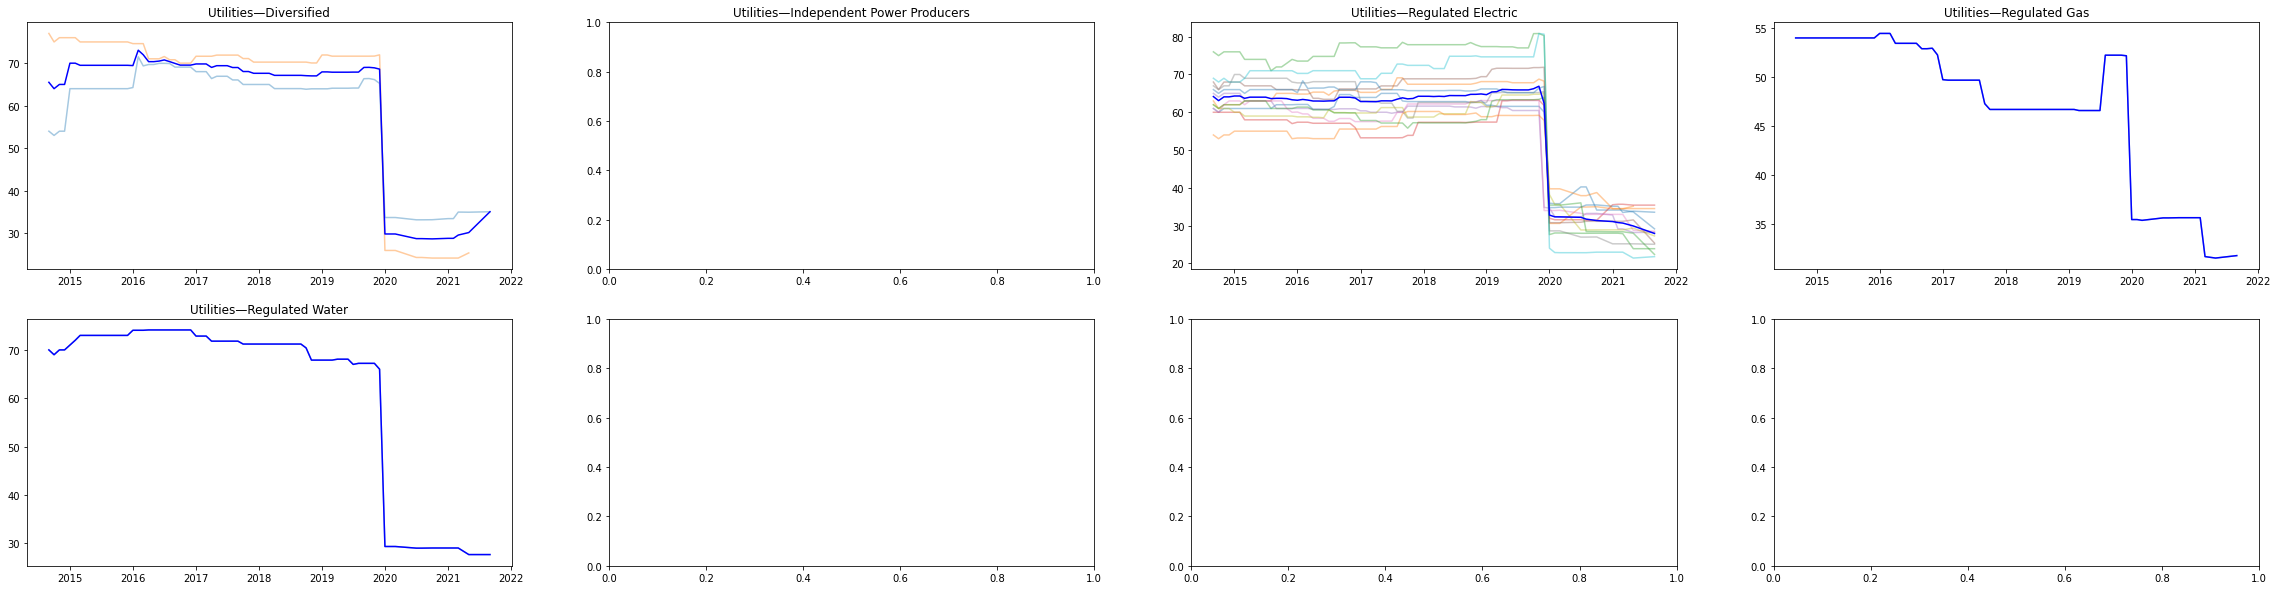

In [22]:
plot_esg_industry('Utilities', asset_profiles, esg_pivot.dropna(axis = 0, how = 'all'))

## ESG data frane

In [23]:
start = datetime.date(2014,9,1)
end = datetime.date(2021,9,1)
[datetime.date(2014,9,1) + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
all_dates = pd.DataFrame({'date':[datetime.date(2014,9,1) + datetime.timedelta(days=x) for x in range(0, (end-start).days)]})
esg_series_all = pd.merge(all_dates, esg_series,how = 'left', on = 'date')
esg_series_all['ticker'].fillna(method='ffill', inplace=True)
# merge with asset_profiels to get sector
esg_series_all = pd.merge(esg_series_all, asset_profiles, how = 'left', on = 'ticker')
# sort for easier accounting
esg_series_all.sort_values(['sector', 'ticker', 'date'], inplace=True)
esg_series_all

date  Unnamed: 0_x  timestamp  esgScore  governanceScore  \
12     2014-09-01           0.0 2014-09-01     68.00             81.0   
298    2014-10-01           1.0 2014-10-01     67.00             81.0   
587    2014-11-01           2.0 2014-11-01     67.00             79.0   
875    2014-12-01           3.0 2014-12-01     67.00             79.0   
1164   2015-01-01           4.0 2015-01-01     65.00             80.0   
...           ...           ...        ...       ...              ...   
23714  2021-04-01          79.0 2021-04-01       NaN              NaN   
24017  2021-05-01          80.0 2021-05-01     27.99              6.3   
24319  2021-06-01          81.0 2021-06-01       NaN              NaN   
24602  2021-07-01          82.0 2021-07-01       NaN              NaN   
24886  2021-08-01          83.0 2021-08-01       NaN              NaN   

       environmentScore  socialScore ticker  Unnamed: 0_y  \
12                 57.0        71.00    ALB             0   
298                57.0        71.00    ALB             0   
587                57.0        71.00    ALB             0   
875                57.0        71.00    ALB             0   
1164               54.0        67.00    ALB             0   
...                 ...          ...    ...           ...   
23714               NaN          NaN    LNT             0   
24017              14.3         7.38    LNT             0   
24319               NaN          NaN    LNT             0   
24602               NaN          NaN    LNT             0   
24886               NaN          NaN    LNT             0   

                     address       city state    zip        country  \
12      4250 Congress Street  Charlotte    NC  28209  United States   
298     4250 Congress Street  Charlotte    NC  28209  United States   
587     4250 Congress Street  Charlotte    NC  28209  United States   
875     4250 Congress Street  Charlotte    NC  28209  United States   
1164    4250 Congress Street  Charlotte    NC  28209  United States   
...                      ...        ...   ...    ...            ...   
23714  4902 N. Biltmore Lane    Madison    WI  53718  United States   
24017  4902 N. Biltmore Lane    Madison    WI  53718  United States   
24319  4902 N. Biltmore Lane    Madison    WI  53718  United States   
24602  4902 N. Biltmore Lane    Madison    WI  53718  United States   
24886  4902 N. Biltmore Lane    Madison    WI  53718  United States   

                           industry           sector  boardRisk  \
12              Specialty Chemicals  Basic Materials        5.0   
298             Specialty Chemicals  Basic Materials        5.0   
587             Specialty Chemicals  Basic Materials        5.0   
875             Specialty Chemicals  Basic Materials        5.0   
1164            Specialty Chemicals  Basic Materials        5.0   
...                             ...              ...        ...   
23714  Utilities—Regulated Electric        Utilities        7.0   
24017  Utilities—Regulated Electric        Utilities        7.0   
24319  Utilities—Regulated Electric        Utilities        7.0   
24602  Utilities—Regulated Electric        Utilities        7.0   
24886  Utilities—Regulated Electric        Utilities        7.0   

       compensationRisk  shareHolderRightsRisk  overallRisk  
12                  6.0                    8.0          7.0  
298                 6.0                    8.0          7.0  
587                 6.0                    8.0          7.0  
875                 6.0                    8.0          7.0  
1164                6.0                    8.0          7.0  
...                 ...                    ...          ...  
23714               3.0                    7.0          5.0  
24017               3.0                    7.0          5.0  
24319               3.0                    7.0          5.0  
24602               3.0                    7.0          5.0  
24886               3.0                    7.0          5.0  



In [24]:
esg_pivot = esg_series_all[['ticker', 'esgScore', 'date']].copy()
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker', dropna= False)
esg_pivot

ticker         A   AAL   AAP  AAPL  ABBV   ABC   ABT   ACN  ADBE   ADI  ...  \
date                                                                    ...   
2014-09-01  73.0  73.0  48.0  61.0  64.0  55.0  64.0  72.0  70.0  66.0  ...   
2014-09-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2014-09-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2014-09-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2014-09-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2021-08-27   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2021-08-28   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2021-08-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2021-08-30   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2021-08-31   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

ticker       MTB  PEAK    RE  SCHW   SJM   STZ     T  TECH   XOM  XRAY  
date                                                                    
2014-09-01  50.0   NaN  45.0  50.0  61.0  54.0  66.0   NaN  66.0  57.0  
2014-09-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2014-09-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2014-09-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2014-09-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2021-08-27   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2021-08-28   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2021-08-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2021-08-30   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2021-08-31   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[2557 rows x 282 columns]

Account for group membership

# Data for inference no shift

In [25]:
data_i_will_use = esg_pivot.copy().dropna(axis = 0, how = 'all' ).iloc[:60].copy().dropna(axis = 1, how = 'all' ).copy()
dates = np.array(data_i_will_use.index)

In [26]:
group_membership = []
for i in list(data_i_will_use.columns):
    sector = asset_profiles['sector'].loc[asset_profiles['ticker'] == i].iloc[0]
    if sector == 'Basic Materials':
        group_membership.append(0)
    elif sector == 'Communication Services':
        group_membership.append(1)
    elif sector == 'Consumer Cyclical':
        group_membership.append(2)
    elif sector == 'Consumer Defensive':
        group_membership.append(3)
    elif sector == 'Energy':
        group_membership.append(4)
    elif sector == 'Financial Services':
        group_membership.append(5)
    elif sector == 'Healthcare':
        group_membership.append(6)
    elif sector == 'Industrials':
        group_membership.append(7)
    elif sector == 'Real Estate':
        group_membership.append(8)
    elif sector == 'Technology':
        group_membership.append(9)
    elif sector == 'Utilities':
        group_membership.append(10)

group_membership = np.array(group_membership)

#  Data for inference shift median

Shift all data points up by using the median

In [27]:
data_median_shift = esg_pivot.dropna(axis = 0, how = 'all' ).dropna(axis = 1, how = 'all' ).copy().dropna(axis = 1 ).copy()
dates_median_shift = np.array(data_median_shift.index)

y_shift = np.array([0] * data_median_shift.shape[1])
index = np.array(range(data_median_shift.shape[0]))
for i in range(len(data_median_shift.columns)):
    tmp = index[(data_median_shift.iloc[:,i].index > datetime.date(2019,9,1)) & (data_median_shift.iloc[:,i].diff() < -10)]
    if len(tmp) == 0:
        y_shift[i] = 999999  # no shift
    else:
        y_shift[i] = tmp[0]


shifts = np.array([0] * data_median_shift.shape[1])
for i, company in enumerate(data_median_shift.columns):
    if y_shift[i] == 999999:  # no shift
        shifts[i] = 0
    else:
        shifts[i] = np.nanmedian(data_median_shift.iloc[:y_shift[i], i]) - np.nanmedian(data_median_shift.iloc[y_shift[i]:, i])


#shift = np.nanmedian(data_median_shift.iloc[:63]) - np.nanmedian(data_median_shift.iloc[63:])
for i, company in enumerate(list(data_median_shift.columns)):
    if y_shift[i] == 999999:
        continue
    else:
        data_median_shift[company].iloc[y_shift[i]:] = data_median_shift[company].iloc[y_shift[i]:] + shifts[i]


group_membership_median_shift_sector = []
group_membership_median_shift_industry = []

for i in list(data_median_shift.columns):

    sector_i_belongs_to = asset_profiles['sector'].loc[asset_profiles['ticker'] == i].iloc[0]
    industry_i_belongs_to = asset_profiles['industry'].loc[asset_profiles['ticker'] == i].iloc[0]

    group_membership_median_shift_sector.append(group_membership_sector[sector_i_belongs_to])
    group_membership_median_shift_industry.append(group_membership_industry[industry_i_belongs_to])

group_membership_median_shift_sector = np.array(group_membership_median_shift_sector)
group_membership_median_shift_industry = np.array(group_membership_median_shift_industry)



In [28]:
data_median_shift

ticker          A    AAL   AAP   AAPL   ABBV    ABC    ABT    ACN   ADBE  \
date                                                                       
2014-09-01  73.00  73.00  48.0  61.00  64.00  55.00  64.00  72.00  70.00   
2014-10-01  71.00  73.00  48.0  60.00  62.00  55.00  64.00  72.00  70.00   
2014-11-01  73.00  73.00  48.0  61.00  66.00  55.00  64.00  72.00  70.00   
2014-12-01  73.00  72.00  47.0  61.00  66.00  55.00  64.00  72.00  70.00   
2015-01-01  73.00  49.00  47.0  61.00  66.00  55.00  64.00  72.00  70.00   
...           ...    ...   ...    ...    ...    ...    ...    ...    ...   
2020-10-01  65.72  52.62  47.4  66.65  65.86  52.90  63.85  73.24  68.32   
2021-01-01  65.64  52.62  47.4  59.46  64.07  52.90  63.85  73.31  65.98   
2021-02-01  65.64  51.93  47.1  59.58  64.07  52.82  63.85  73.31  65.88   
2021-03-01  65.57  51.93  47.1  59.73  64.07  52.43  63.85  73.31  65.88   
2021-05-01  65.57  50.03  47.1  59.92  64.07  52.83  63.98  73.31  65.88   

ticker        ADI  ...    MRK    MRO    MTB     RE   SCHW    SJM    STZ  \
date               ...                                                    
2014-09-01  66.00  ...  78.00  62.00  50.00  45.00  50.00  61.00  54.00   
2014-10-01  64.00  ...  77.00  62.00  50.00  45.00  50.00  61.00  54.00   
2014-11-01  66.00  ...  78.00  62.00  50.00  45.00  50.00  60.00  54.00   
2014-12-01  66.00  ...  78.00  62.00  50.00  45.00  50.00  60.00  54.00   
2015-01-01  66.00  ...  78.00  61.00  49.00  45.00  51.00  60.00  54.00   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2020-10-01  72.17  ...  67.85  61.91  47.55  47.07  48.79  62.27  53.39   
2021-01-01  72.17  ...  63.50  61.11  47.55  37.16  49.27  62.34  53.29   
2021-02-01  71.75  ...  63.50  61.11  47.23  37.16  49.27  62.34  53.29   
2021-03-01  71.75  ...  63.98  61.11  47.23  37.16  49.27  62.34  53.29   
2021-05-01  71.54  ...  63.98  61.80  47.23  37.16  49.27  61.95  53.45   

ticker          T    XOM   XRAY  
date                             
2014-09-01  66.00  66.00  57.00  
2014-10-01  65.00  65.00  57.00  
2014-11-01  65.00  66.00  57.00  
2014-12-01  62.00  66.00  57.00  
2015-01-01  65.00  65.00  58.00  
...           ...    ...    ...  
2020-10-01  65.07  62.33  56.50  
2021-01-01  65.07  62.27  56.09  
2021-02-01  65.07  62.27  56.07  
2021-03-01  65.07  65.11  56.07  
2021-05-01  65.07  64.89  56.07  

[74 rows x 249 columns]

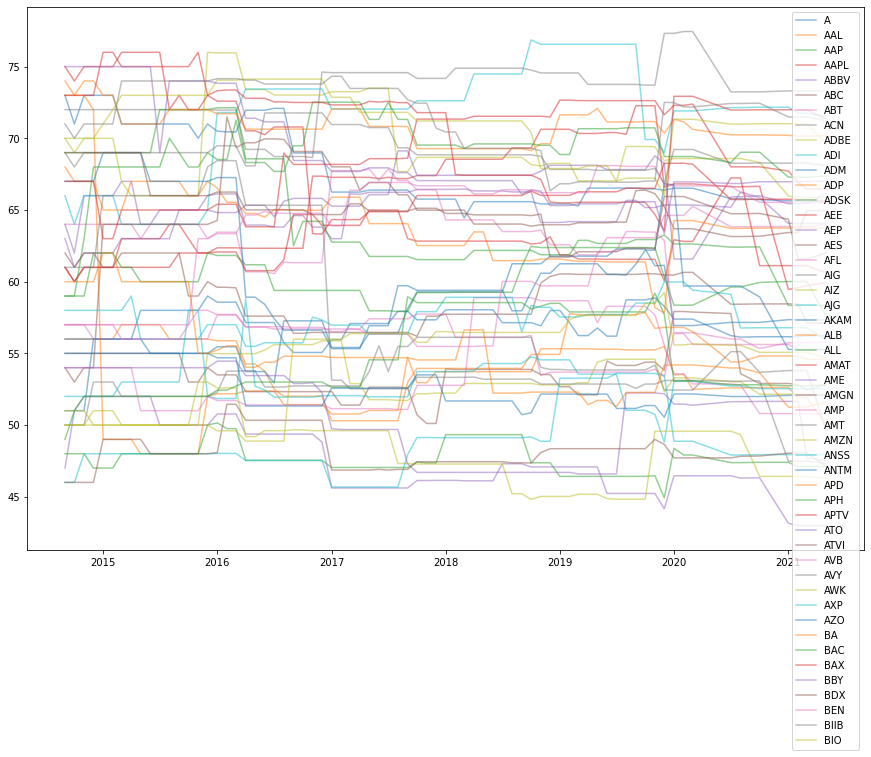

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for i in range(data_median_shift.shape[1]-200):
    out = plt.plot(dates_median_shift, data_median_shift.iloc[:,i], alpha = 0.5)
    legend_ticks.append(data_median_shift.columns[i])

plt.legend(legend_ticks)

# Frequentist estimation

Let's start by doing a frequentist estimation

In [22]:
importlib.reload(sys.modules['Gibbs'])
y = np.array(data_median_shift)
n_stock = y.shape[1]
n_groups = len(np.unique(group_membership_median_shift_sector))
beta_vec = np.array([0.1] * n_stock + [0.1] * n_stock )
index = np.array(range(n_stock))


param = [0.1] * n_stock + [0.1] * n_stock  # beta
param = param + [0.0] * (1 + n_groups)  # eta
param = param + list(np.nanmean(y, axis = 0))  # a
#param = param + [1.0] * (1 + n_groups)  # w
#param = param + [5.0] * (n_stock)  # v
param = param + [1.0]
param = param + [5.0]
param = np.array(param, dtype= np.float32)

#Gibbs.lc_sector_ml(np.array(param), y, group_membership_median_shift)


out = scipy.optimize.minimize(fun = Gibbs.lc_sector_ml_2, x0 = param, args = (y, group_membership_median_shift_sector), method = 'Nelder-Mead')





0.0 vs 0.0
negative likelihood 24826.196480899172
0.10000000149011612
24826.196480899172
0.0 vs 0.0
negative likelihood 24826.05479344241
0.10500000156462193
24826.05479344241
0.0 vs 0.0
negative likelihood 24826.324855900202
0.10000000149011612
24826.324855900202
0.0 vs 0.0
negative likelihood 24826.28925501992
0.10000000149011612
24826.28925501992
0.0 vs 0.0
negative likelihood 24826.119931065183
0.10000000149011612
24826.119931065183
0.0 vs 0.0
negative likelihood 24826.309178142325
0.10000000149011612
24826.309178142325
0.0 vs 0.0
negative likelihood 24826.16779373298
0.10000000149011612
24826.16779373298
0.0 vs 0.0
negative likelihood 24826.463566924464
0.10000000149011612
24826.463566924464
0.0 vs 0.0
negative likelihood 24826.401295041105
0.10000000149011612
24826.401295041105
0.0 vs 0.0
negative likelihood 24826.307785169323
0.10000000149011612
24826.307785169323
0.0 vs 0.0
negative likelihood 24826.60312658824
0.10000000149011612
24826.60312658824
0.0 vs 0.0
negative likelihoo

KeyboardInterrupt: 

# Model for each stock

Fit a model of the type

$$ y_t = \alpha_x + \beta_t \kappa_t + v $$
$$ \kappa_t = \kappa_{t-1} + \eta + w$$

In [126]:
#data_i_will_use = esg_pivot.copy().dropna(axis = 0, how = 'all' ).iloc[:75]# .copy().dropna(axis = 1, how = 'all' ).dropna(axis = 1 ).copy()
bool = np.array([i.day for i in esg_pivot.index]) == 1
data_i_will_use = esg_pivot.loc[bool]
data_i_will_use = data_i_will_use.iloc[:40]
data_i_will_use

A    AAL    AAP   AAPL   ABBV    ABC    ABT    ACN   ADBE  \
date                                                                        
2014-09-01  73.00  73.00  48.00  61.00  64.00  55.00  64.00  72.00  70.00   
2014-10-01  71.00  73.00  48.00  60.00  62.00  55.00  64.00  72.00  70.00   
2014-11-01  73.00  73.00  48.00  61.00  66.00  55.00  64.00  72.00  70.00   
2014-12-01  73.00  72.00  47.00  61.00  66.00  55.00  64.00  72.00  70.00   
2015-01-01  73.00  49.00  47.00  61.00  66.00  55.00  64.00  72.00  70.00   
2015-02-01  73.00  49.00  47.00  61.00  66.00  55.00  64.00  72.00  70.00   
2015-03-01  71.00  49.00  48.00  63.00  67.00  55.00  64.00  72.00  67.00   
2015-04-01  71.00  49.00  48.00  63.00  67.00  55.00  64.00  72.00  66.00   
2015-05-01  71.00  48.00  48.00  63.00  64.00  55.00  63.00  72.00  66.00   
2015-06-01  71.00  48.00  48.00  63.00  64.00  55.00  64.00  72.00  66.00   
2015-07-01  71.00  48.00  48.00  63.00  65.00  55.00  64.00  72.00  66.00   
2015-08-01  71.00  48.00  48.00  64.00  65.00  55.00  64.00  72.00  66.00   
2015-09-01  71.00  48.00  48.00  64.00  65.00  55.00  64.00  72.00  66.00   
2015-10-01  71.00  48.00  48.00  63.00  65.00  53.00  64.00  72.00  66.00   
2015-11-01  70.00  48.00  48.00  62.00  65.00  53.00  64.00  72.00  66.00   
2015-12-01  71.00  52.00  50.00  62.00  66.00  54.00  63.00  72.00  76.00   
2016-01-01  70.50  52.18  50.15  62.36  66.12  53.50  63.45  71.97  75.96   
2016-02-01  70.45  52.18  49.75  62.36  66.12  53.50  63.45  71.97  75.96   
2016-03-01  70.45  52.18  49.75  62.36  66.12  53.50  63.45  71.97  75.96   
2016-04-01  71.96  52.38  47.54  62.33  63.95  52.33  60.69  69.23  73.40   
2016-05-01  71.96  52.38  47.54  62.33  63.95  52.33  60.69  69.23  73.40   
2016-06-01  71.96  52.38  47.54  62.33  63.95  52.33  60.69  69.23  73.40   
2016-07-01  72.09  52.38  47.54  62.33  63.81  52.33  60.56  68.73  73.02   
2016-08-01  72.09  51.43  47.54  62.33  63.81  52.33  61.36  68.73  73.02   
2016-09-01  68.98  51.43  47.54  62.33  64.61  52.33  61.32  68.73  73.02   
2016-10-01  68.98  51.43  47.54  62.33  64.61  52.33  61.32  68.73  73.02   
2016-11-01  68.98  51.43  47.54  67.36  63.81  52.33  61.32  68.66  73.02   
2016-12-01  68.98  51.43  47.54  67.36  63.81  52.33  61.32  74.62  73.02   
2017-01-01  66.25  50.77  47.04  67.28  63.00  52.34  67.74  74.58  73.25   
2017-02-01  66.25  50.77  47.04  67.28  63.00  51.39  67.74  74.58  73.25   
2017-03-01  66.25  50.77  47.04  67.28  66.13  51.39  67.74  74.58  73.25   
2017-04-01  66.25  50.77  47.04  67.28  66.09  51.39  67.74  74.58  73.25   
2017-05-01  66.39  51.02  47.04  67.28  66.23  52.64  67.86  74.58  73.50   
2017-06-01  66.39  51.02  47.04  67.19  66.23  52.64  67.06  74.58  73.50   
2017-07-01  66.39  51.02  47.04  67.28  66.23  52.64  67.86  74.58  73.50   
2017-08-01  66.39  51.02  47.04  67.19  66.23  52.64  67.06  74.58  67.68   
2017-09-01  66.39  54.73  47.04  67.19  66.23  52.60  67.06  74.58  67.68   
2017-10-01  65.76  52.96  47.42  67.40  66.44  50.71  66.41  74.18  68.67   
2017-11-01  65.76  52.96  47.36  67.40  66.44  50.11  66.41  74.18  68.67   
2017-12-01  65.76  53.72  47.36  67.40  66.44  50.11  66.41  74.18  68.67   

              ADI  ...  PEAK     RE   SCHW    SJM    STZ      T    TAP  TECH  \
date               ...                                                         
2014-09-01  66.00  ...   NaN  45.00  50.00  61.00  54.00  66.00  73.00   NaN   
2014-10-01  64.00  ...   NaN  45.00  50.00  61.00  54.00  65.00  73.00   NaN   
2014-11-01  66.00  ...   NaN  45.00  50.00  60.00  54.00  65.00  73.00   NaN   
2014-12-01  66.00  ...   NaN  45.00  50.00  60.00  54.00  62.00  73.00   NaN   
2015-01-01  66.00  ...   NaN  45.00  51.00  60.00  54.00  65.00  73.00   NaN   
2015-02-01  66.00  ...   NaN  45.00  51.00  60.00  54.00  65.00  73.00   NaN   
2015-03-01  64.00  ...   NaN  45.00  50.00  62.00  54.00  64.00  71.00   NaN   
2015-04-01  64.00  ...   NaN  45.00  50.00  62.00  54.00  64.

In [137]:
stock_nr = 0
y = np.array(data_i_will_use)
y = y[:,stock_nr, np.newaxis]
n_stock = 1

## Inital parameters and prior specification
init_params = dict()

# init prior
# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array([np.nanmean(y)] * n_stock )
init_params['alpha_var'] = np.array([2.0] * n_stock) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * 1)
init_params['eta_var'] = np.array([2.0] * 1)

# each v follows an inverse gamma
init_params['v_alpha'] = 2.1 
init_params['v_beta'] = 1

# each w follows an inverse gamma
init_params['w_alpha'] = 2.1
init_params['w_beta'] = 1

# init gibbs
# init_params['beta_init'] = np.array([0.1] * n_stock)
init_params['alpha_init'] = np.nanmean(y, axis = 0)
init_params['eta_init'] = 0.0 * np.ones(1) 
init_params['w_init'] =  1.0 * np.ones(1) 
init_params['v_init'] = 1.0 * np.ones(n_stock) 

# init kalman
init_params['init_x'] = np.array([0.0] * (1))
init_params['init_c'] = np.identity((1)) * 100

In [138]:
importlib.reload(sys.modules['Gibbs'])
w_lc_single, v_lc_single, beta_lc_single, A_lc_single, eta_lc_single, states_single, R_conds_single = Gibbs.lc_single(1000, y, init_params)


1
1 of 1000 
0.0 vs 0.0
negative likelihood 27.863375754840444
2 of 1000 
0.0 vs 0.0
negative likelihood 31.039181794073603
3 of 1000 
0.0 vs 0.0
negative likelihood 27.47623294696983
4 of 1000 
0.0 vs 0.0
negative likelihood 30.935036131534293
5 of 1000 
0.0 vs 0.0
negative likelihood 27.731587331295895
6 of 1000 
0.0 vs 0.0
negative likelihood 28.52170749083903
7 of 1000 
0.0 vs 0.0
negative likelihood 21.59122297912703
8 of 1000 
0.0 vs 0.0
negative likelihood 19.014992030528354
9 of 1000 
0.0 vs 0.0
negative likelihood 23.96689572237495
10 of 1000 
0.0 vs 0.0
negative likelihood 27.962589883843354
11 of 1000 
0.0 vs 0.0
negative likelihood 31.41161841042983
12 of 1000 
0.0 vs 0.0
negative likelihood 27.281301681459574
13 of 1000 
0.0 vs 0.0
negative likelihood 25.20453057823902
14 of 1000 
0.0 vs 0.0
negative likelihood 26.553436815540287
15 of 1000 
0.0 vs 0.0
negative likelihood 23.04898654579434
16 of 1000 
0.0 vs 0.0
negative likelihood 18.65374682336341
17 of 1000 
0.0 vs 0.0


Text(0.5, 1.0, 'variance_x, x= 0')

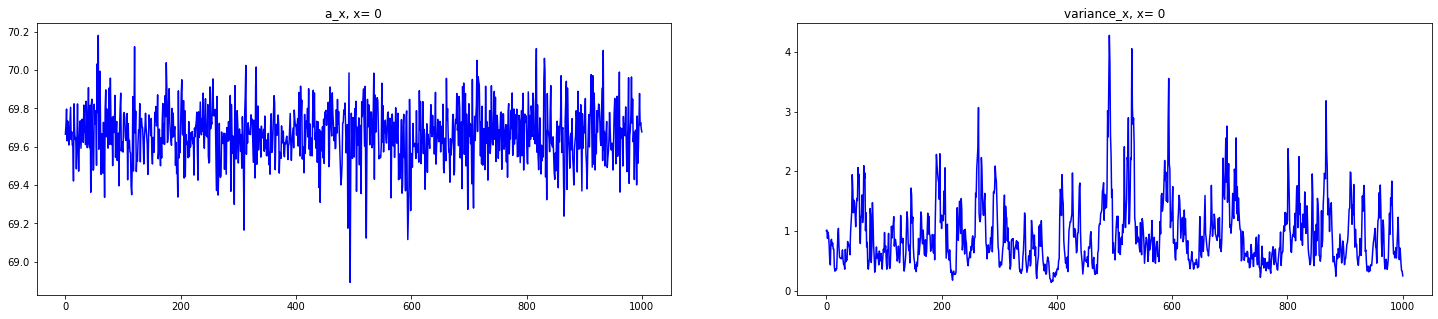

In [139]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,2, figsize = (25,5))
ax[0].plot(range(A_lc_single.shape[0]),A_lc_single[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
#ax[1].plot(range(beta_lc_single.shape[0]),beta_lc_single[:,index], color='b')
#ax[1].set_title(f'beta_x, x= {index}')
ax[1].plot(range(v_lc_single.shape[0]),v_lc_single[:,index], color='b')
ax[1].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 10, ymin = 0)

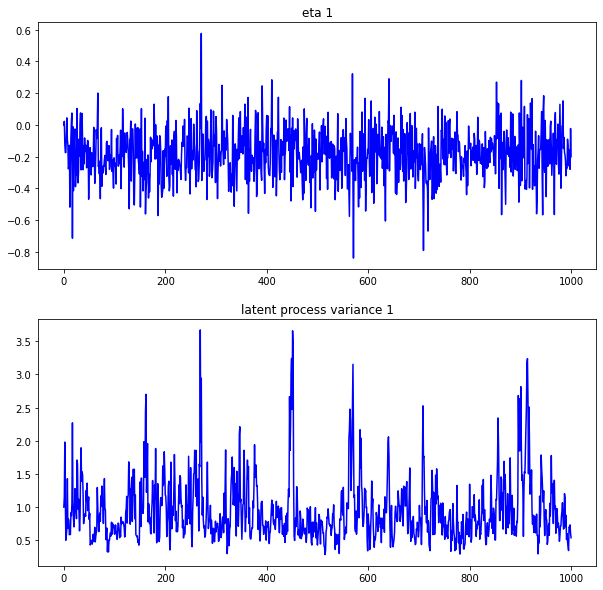

In [136]:
fig, ax = plt.subplots(2,1, figsize = (10,10))
for j in range(1):
        ax[0].plot(range(eta_lc_single.shape[0]),eta_lc_single[:,j], color='b')
        ax[0].set_title(f'eta {j+1}')
        ax[1].plot(range(w_lc_single.shape[0]),w_lc_single[:,j], color='b')
        ax[1].set_title(f'latent process variance {j+1}')

Text(0.5, 1.0, 'Latent processes')

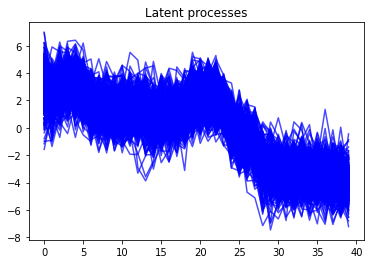

In [140]:
for i in range(states_single.shape[0]):
    plt.plot(range(states_single.shape[1]), states_single[i, :, 0], color = 'blue', alpha =0.7)

plt.title("Latent processes")

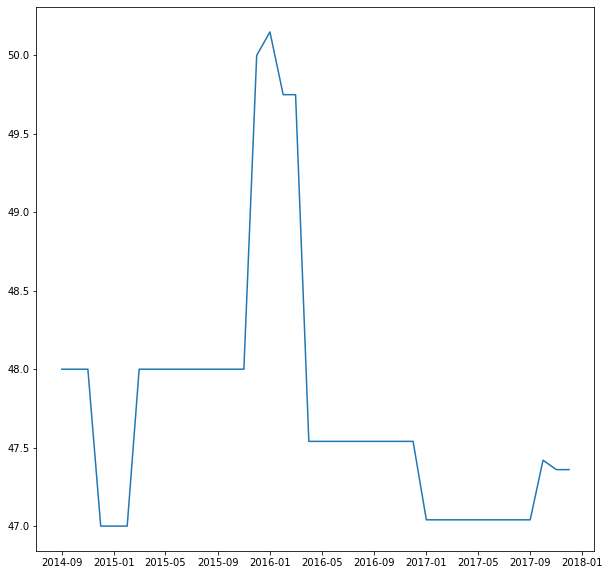

In [117]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(data_i_will_use.index, data_i_will_use.iloc[:, stock_nr])


# Model for the each sector

Fit a model of the type

$$ y_t = \alpha_x + \beta_t \kappa_t + v $$
$$ \kappa_t = \kappa_{t-1} + \eta + w$$

now, $y$, and $v$ are vectors.


In [62]:
#data_i_will_use = esg_pivot.copy().dropna(axis = 0, how = 'all' ).iloc[:75]# .copy().dropna(axis = 1, how = 'all' ).dropna(axis = 1 ).copy()
bool = np.array([i.day for i in esg_pivot.index]) == 1  # beginning of each month
data_i_will_use = esg_pivot.loc[bool]
#data_i_will_use = data_i_will_use.iloc[:40]
data_i_will_use = data_i_will_use.copy().dropna(axis = 0, how = 'all' )

for col in data_i_will_use.columns:
    nr_na = np.sum(np.isnan(data_i_will_use[col]))
    if nr_na > 10:
        data_i_will_use = data_i_will_use.drop(col, 1)

data_i_will_use

A    AAL    AAP   AAPL   ABBV    ABC    ABT    ACN   ADBE  \
date                                                                        
2014-09-01  73.00  73.00  48.00  61.00  64.00  55.00  64.00  72.00  70.00   
2014-10-01  71.00  73.00  48.00  60.00  62.00  55.00  64.00  72.00  70.00   
2014-11-01  73.00  73.00  48.00  61.00  66.00  55.00  64.00  72.00  70.00   
2014-12-01  73.00  72.00  47.00  61.00  66.00  55.00  64.00  72.00  70.00   
2015-01-01  73.00  49.00  47.00  61.00  66.00  55.00  64.00  72.00  70.00   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-01-01  16.64  30.62  12.40  16.46  29.07  12.90  29.85  11.31  10.98   
2021-02-01  16.64  29.93  12.10  16.58  29.07  12.82  29.85  11.31  10.88   
2021-03-01  16.57  29.93  12.10  16.73  29.07  12.43  29.85  11.31  10.88   
2021-05-01  16.57  28.03  12.10  16.92  29.07  12.83  29.98  11.31  10.88   
2021-09-01  16.57  29.81  12.58  16.92  27.38  13.00  25.96  11.41  10.78   

              ADI  ...    MRK    MRO    MTB     RE   SCHW    SJM    STZ  \
date               ...                                                    
2014-09-01  66.00  ...  78.00  62.00  50.00  45.00  50.00  61.00  54.00   
2014-10-01  64.00  ...  77.00  62.00  50.00  45.00  50.00  61.00  54.00   
2014-11-01  66.00  ...  78.00  62.00  50.00  45.00  50.00  60.00  54.00   
2014-12-01  66.00  ...  78.00  62.00  50.00  45.00  50.00  60.00  54.00   
2015-01-01  66.00  ...  78.00  61.00  49.00  45.00  51.00  60.00  54.00   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2021-01-01  26.17  ...  22.50  42.11  27.55  18.16  25.27  27.34  23.29   
2021-02-01  25.75  ...  22.50  42.11  27.23  18.16  25.27  27.34  23.29   
2021-03-01  25.75  ...  22.98  42.11  27.23  18.16  25.27  27.34  23.29   
2021-05-01  25.54  ...  22.98  42.80  27.23  18.16  25.27  26.95  23.45   
2021-09-01  23.82  ...  22.39  42.72  27.23  18.16  24.41  26.64    NaN   

                T    XOM   XRAY  
date                             
2014-09-01  66.00  66.00  57.00  
2014-10-01  65.00  65.00  57.00  
2014-11-01  65.00  66.00  57.00  
2014-12-01  62.00  66.00  57.00  
2015-01-01  65.00  65.00  58.00  
...           ...    ...    ...  
2021-01-01  19.07  32.27  20.09  
2021-02-01  19.07  32.27  20.07  
2021-03-01  19.07  35.11  20.07  
2021-05-01  19.07  34.89  20.07  
2021-09-01  19.13  35.77  20.07  

[75 rows x 257 columns]

In [100]:
sector_classification.keys()

dict_keys(['Industrials', 'Healthcare', 'Technology', 'Communication Services', 'Consumer Cyclical', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Consumer Defensive', 'Energy'])

In [129]:
sector = 'Energy'
y = np.array(data_i_will_use.loc[:, data_i_will_use.columns.isin(sector_classification[sector])])
#y = y[:,stock_nr, np.newaxis]
n_stock = y.shape[1]

## Inital parameters and prior specification
init_params = dict()

# init prior

# each beta follows a normal distribution
init_params['beta_mean'] = 1.0/n_stock
init_params['beta_var'] = 0.1

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array([np.nanmean(y)] * n_stock )
init_params['alpha_var'] = np.array([2.0] * n_stock) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * 1)
init_params['eta_var'] = np.array([2.0] * 1)

# each v follows an inverse gamma
init_params['v_alpha'] = 2.1 
init_params['v_beta'] = 1

# each w follows an inverse gamma
init_params['w_alpha'] = 2.1
init_params['w_beta'] = 1

# init gibbs
init_params['beta_init'] = np.array([0.1] * n_stock)
init_params['alpha_init'] = np.nanmean(y, axis = 0)
init_params['eta_init'] = 0.0 * np.ones(1) 
init_params['w_init'] =  1.0 * np.ones(1) 
init_params['v_init'] = 1.0 * np.ones(n_stock) 

# init kalman
init_params['init_x'] = np.array([0.0] * (1))
init_params['init_c'] = np.identity((1)) * 100

In [130]:
importlib.reload(sys.modules['Gibbs'])
w_sector, v_sector, beta_sector, A_sector, eta_sector, states_sector, R_conds_sector = Gibbs.lc_single(1000, y, init_params)


100%|██████████| 1000/1000 [00:22<00:00, 43.95it/s]


Text(0.5, 1.0, 'variance_x, x= 0')

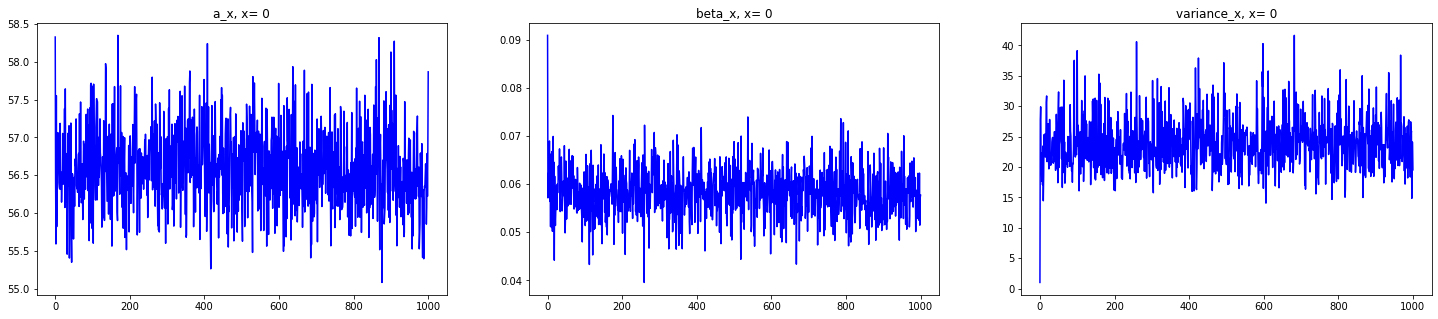

In [132]:
index = 0
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_sector.shape[0]),A_sector[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_sector.shape[0]),beta_sector[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_sector.shape[0]),v_sector[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 10, ymin = 0)

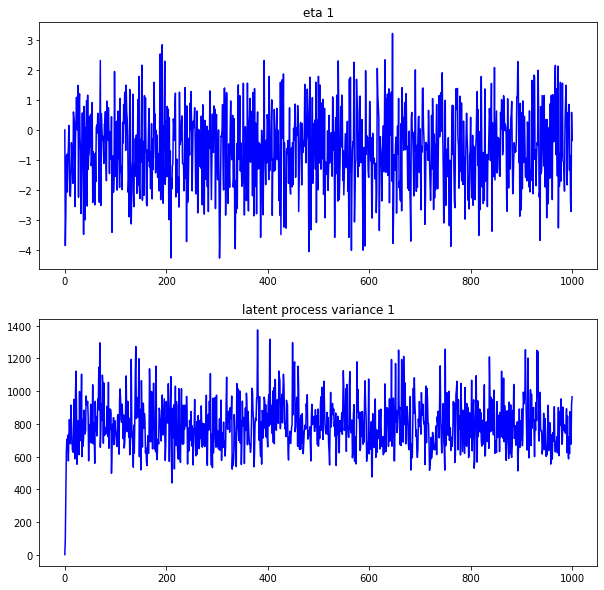

In [133]:
fig, ax = plt.subplots(2,1, figsize = (10,10))
for j in range(1):
        ax[0].plot(range(eta_sector.shape[0]),eta_sector[:,j], color='b')
        ax[0].set_title(f'eta {j+1}')
        ax[1].plot(range(w_sector.shape[0]),w_sector[:,j], color='b')
        ax[1].set_title(f'latent process variance {j+1}')

Text(0.5, 1.0, 'Latent processes')

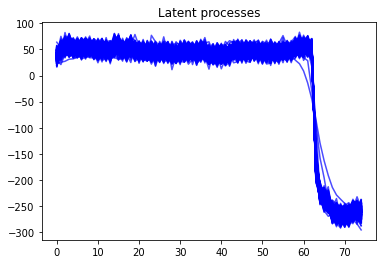

In [134]:
for i in range(states_sector.shape[0]):
    plt.plot(range(states_sector.shape[1]), states_sector[i, :, 0], color = 'blue', alpha =0.7)

plt.title("Latent processes")

# Lee-Carter, esg sector

Up until now I am simply adding the regularization into the Gibbs sampler function, Not optimal. Will change this. Here I shift 

First create the group membership vector

In [37]:
data_i_will_use = esg_pivot.copy().dropna(axis = 0, how = 'all' ).iloc[:40].copy().dropna(axis = 1, how = 'all' ).copy().dropna(axis = 1 ).copy()
dates = np.array(data_i_will_use.index)
dates = np.array(data_i_will_use.index)

group_membership_median_shift_sector = []
group_membership_median_shift_industry = []

for i in list(data_i_will_use.columns):

    sector_i_belongs_to = asset_profiles['sector'].loc[asset_profiles['ticker'] == i].iloc[0]
    industry_i_belongs_to = asset_profiles['industry'].loc[asset_profiles['ticker'] == i].iloc[0]

    group_membership_median_shift_sector.append(group_membership_sector[sector_i_belongs_to])
    group_membership_median_shift_industry.append(group_membership_industry[industry_i_belongs_to])

group_membership_median_shift_sector = np.array(group_membership_median_shift_sector)
group_membership_median_shift_industry = np.array(group_membership_median_shift_industry)

In [78]:

y = np.array(data_i_will_use)
n_stock = y.shape[1]
n_groups = len(np.unique(group_membership_median_shift_sector))

## Inital parameters and prior specification
init_params = dict()

# init prior
# each beta follows a normal distribution
init_params['beta_mean'] = 0.0
init_params['beta_var'] = 0.1

# each alpha follows a normal distribution
init_params['alpha_mean'] = np.array([np.nanmean(y)] * n_stock )
init_params['alpha_var'] = np.array([2.0] * n_stock) 

# each eta follows a normal distribution
init_params['eta_mean'] = np.array([0.0] * (1 + n_groups))
init_params['eta_var'] = np.array([0.1] * (1 + n_groups))

# each v follows an inverse gamma
init_params['v_alpha'] = 2.1 
init_params['v_beta'] = 0.011

# each w follows an inverse gamma
init_params['w_alpha'] = 2.1
init_params['w_beta'] = 0.011

# init gibbs
init_params['beta_init'] = np.array([0.1] * n_stock + [0.1] * n_stock )
init_params['alpha_init'] = np.nanmean(y, axis = 0)
init_params['eta_init'] = 0.0 * np.ones(1 + n_groups) 
init_params['w_init'] =  1.0 * np.ones(1 + n_groups) 
init_params['v_init'] = 1.0 * np.ones(n_stock) 

# init kalman
init_params['init_x'] = np.array([0.0] * (1+n_groups))
init_params['init_c'] = np.identity((1 + n_groups)) * 10


In [84]:
importlib.reload(sys.modules['Gibbs'])
w_lc_s_no_reg, v_lc_s_no_reg, beta_lc_s_no_reg, A_lc_s_no_reg, eta_lc_s_no_reg, states_lc_s_no_reg, R_conds = Gibbs.lc_sector(10000, y, group_membership_median_shift_sector, init_params)


T 40, n_stock 255, n_groups 11
1 of 10000 
0.0 vs 0.0
negative likelihood 23498.15496305635
2 of 10000 
0.0 vs 0.0
negative likelihood 7165.458657232017
3 of 10000 


C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:163: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[-1] = np.random.multivariate_normal(smooth_state[-1], smooth_state_cov[-1])
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:177: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])


0.0 vs 0.0
negative likelihood 6447.035590890342
4 of 10000 
0.0 vs 0.0
negative likelihood 6081.548127349541
5 of 10000 
0.0 vs 0.0
negative likelihood 5795.783357744356
6 of 10000 
0.0 vs 0.0
negative likelihood 5809.272760557754
7 of 10000 
0.0 vs 0.0
negative likelihood 5832.462412713516
8 of 10000 
0.0 vs 0.0
negative likelihood 7181.357339616711
9 of 10000 
0.0 vs 0.0
negative likelihood 6856.000098193055
10 of 10000 
0.0 vs 0.0
negative likelihood 7129.653669288811
11 of 10000 
0.0 vs 0.0
negative likelihood 6523.0162260271545
12 of 10000 
0.0 vs 0.0
negative likelihood 6216.232143842573
13 of 10000 
0.0 vs 0.0
negative likelihood 6072.304679923066
14 of 10000 
0.0 vs 0.0
negative likelihood 8370.598022527545
15 of 10000 
0.0 vs 0.0
negative likelihood 7484.696224931408
16 of 10000 
0.0 vs 0.0
negative likelihood 7078.549847656906
17 of 10000 
0.0 vs 0.0
negative likelihood 6491.129152332102
18 of 10000 
0.0 vs 0.0
negative likelihood 6056.980139337425
19 of 10000 
0.0 vs 0.0
ne

In [85]:
# save data 
import pickle
data_no_reg = {'w':w_lc_s_no_reg,
               'v':v_lc_s_no_reg,
               'beta':beta_lc_s_no_reg,
               'A':A_lc_s_no_reg,
               'eta':eta_lc_s_no_reg,
               'states':states_lc_s_no_reg,
               'cond':R_conds}

with open('../data/lc_s_no_reg.pkl', 'wb') as f:
        pickle.dump(data_no_reg, f)

In [14]:
# load data
# with open('../data/lc_s_no_reg.pkl', 'rb') as f:
#     data_no_reg = pickle.load(f)

# A_lc_s_no_reg = data_no_reg['A']
# beta_lc_s_no_reg = data_no_reg['beta']
# v_lc_s_no_reg = data_no_reg['v']
# eta_lc_s_no_reg = data_no_reg['eta']
# w_lc_s_no_reg = data_no_reg['w']
# states_lc_s_no_reg = data_no_reg['states']


MCMC Analysis

Text(0.5, 1.0, 'variance_x, x= 50')

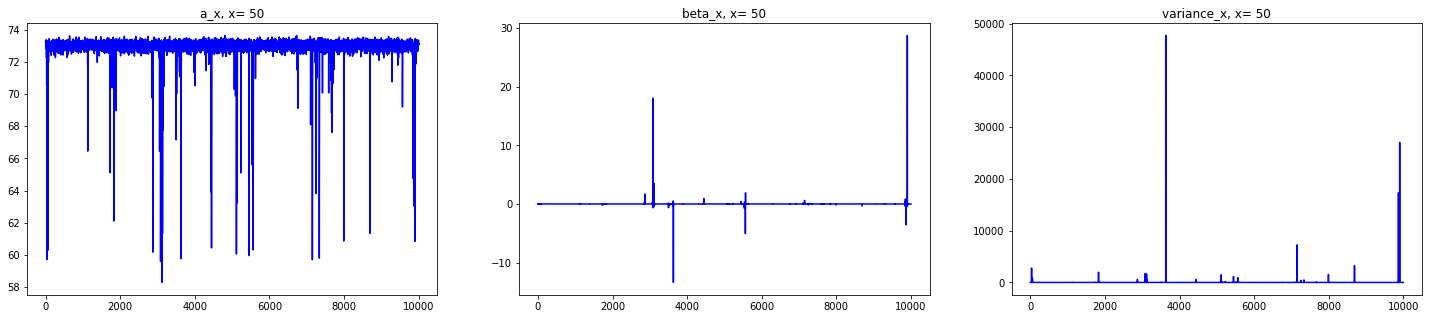

In [86]:
index = 50
# print(f'a_x = {A_vec_lc_s[index]}, beta_i = {beta_vec_lc_s[index]}, v = {v_lc_s[index]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A_lc_s_no_reg.shape[0]),A_lc_s_no_reg[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(beta_lc_s_no_reg.shape[0]),beta_lc_s_no_reg[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(v_lc_s_no_reg.shape[0]),v_lc_s_no_reg[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 10, ymin = 0)

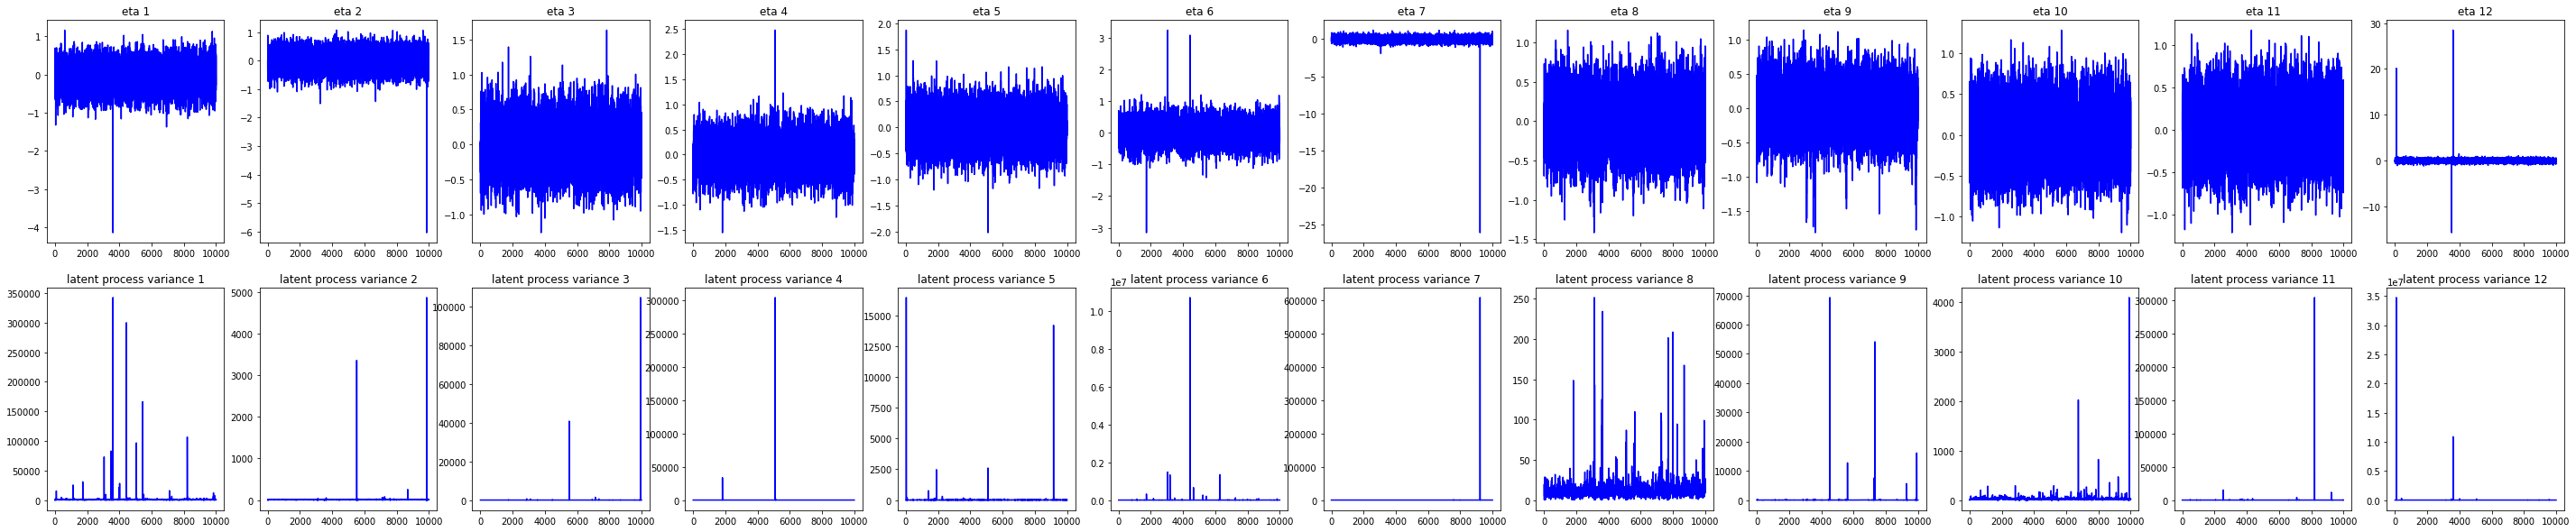

In [87]:
fig, ax = plt.subplots(2,12, figsize = (50,10))
for j in range(12):
        ax[0,j].plot(range(eta_lc_s_no_reg.shape[0]),eta_lc_s_no_reg[:,j], color='b')
        ax[0,j].set_title(f'eta {j+1}')
        ax[1,j].plot(range(w_lc_s_no_reg.shape[0]),w_lc_s_no_reg[:,j], color='b')
        ax[1,j].set_title(f'latent process variance {j+1}')

Text(0.5, 1.0, 'Latent processes')

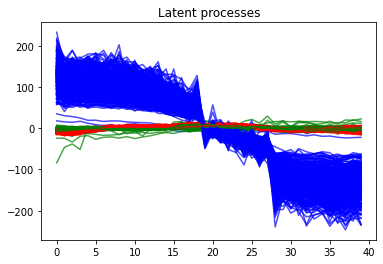

In [57]:
for i in range(states_lc_s_no_reg.shape[0]):
    plt.plot(range(states_lc_s_no_reg.shape[1]), states_lc_s_no_reg[i, :, 0], color = 'blue', alpha =0.7)
    plt.plot(range(states_lc_s_no_reg.shape[1]), states_lc_s_no_reg[i, :, 1], color = 'red', alpha =0.7)
    plt.plot(range(states_lc_s_no_reg.shape[1]), states_lc_s_no_reg[i, :, 2], color = 'green', alpha =0.7)

plt.title("Latent processes")

# Simulation

Test gibbs sampler for simulated data

In [22]:
eta = np.array([-0.01, -0.15, -0.1, -0.07, -0.08])
w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])
beta_i = np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.random.uniform(0.01, 0.8, 40)
a_x = np.random.uniform(50, 80, 40)
N = 50
v = np.random.uniform(0.02, 0.08, 40)

yo = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)

x = np.zeros((N + 1, 5))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = w[0])
    x[i, 1] = x[i-1, 1] + eta[1] + np.random.normal(loc = 0, scale = w[1])
    x[i, 2] = x[i-1, 2] + eta[2] + np.random.normal(loc = 0, scale = w[2])
    x[i, 3] = x[i-1, 3] + eta[3] + np.random.normal(loc = 0, scale = w[3])
    x[i, 4] = x[i-1, 4] + eta[4] + np.random.normal(loc = 0, scale = w[4])

y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        if j < 10:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        elif j < 20:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])
        elif j < 30:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,3] + np.random.normal(0, v[j])
        elif j < 40:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,4] + np.random.normal(0, v[j])

In [23]:
y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        if j < 10:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        elif j < 20:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])
        elif j < 30:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,3] + np.random.normal(0, v[j])
        elif j < 40:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,4] + np.random.normal(0, v[j])
        #y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])


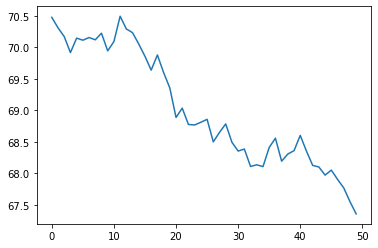

In [214]:
plt.plot(range(N), y[:, 0])

In [360]:
F = np.zeros((40, 1 + 1))
F[:,0] = beta_i
for j in range(F.shape[0]):
    F[j, 1] = beta_s_i[j]

In [24]:
beta_vec = np.concatenate((beta_i, beta_s_i))
F = np.zeros((40, 1 + 4))
F[:,0] = beta_vec[:40]
for j in range(F.shape[0]):
    F[j, yo[j] + 1] = beta_vec[ 40 + j]

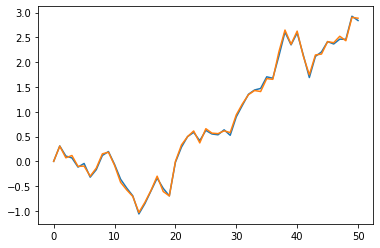

In [25]:

importlib.reload(sys.modules['Gibbs'])
state, state_cov, state_one_step, state_cov_one_step, y_est, R_cond = Gibbs.KalmanFilter(y, np.identity(5), B = eta, W = np.diag(w), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(5), init_c = np.diag([1,1,1,1,1]))
plt.plot(range(N+1), state[:, 0])
plt.plot(range(N+1), x[:, 0])

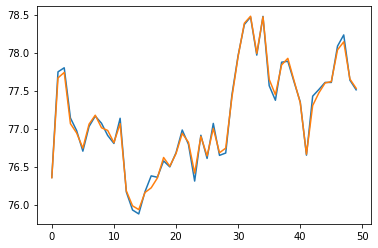

In [26]:
plt.plot(range(N), y[:,24])
plt.plot(range(N), y_est[:,24])

In [144]:
state_cov_one_step.shape

(50, 5, 5)

In [146]:
importlib.reload(sys.modules['Gibbs'])
smooth_state, smooth_state_cov = Gibbs.KalmanSmooth(state, state_one_step,state_cov,state_cov_one_step, np.identity(5), eta, np.diag(w))

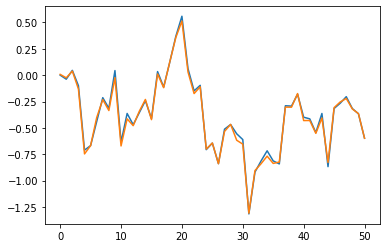

In [150]:
plt.plot(range(N+1), state[:, 0])
plt.plot(range(N+1), smooth_state[:, 0])

In [164]:
smooth_state_draws = np.zeros((100, state.shape[0], state.shape[1]))
for i in range(100):
    smooth_state_draws[i], R_cond = Gibbs.FFBS(y, np.identity(5), B = eta, W = np.diag(w), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(5), init_c = np.diag([0.1,0.1,0.1,0.1,0.1]))

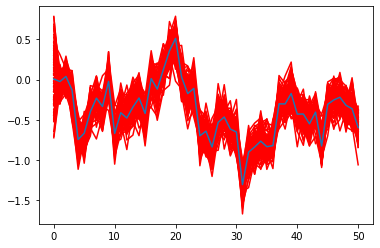

In [165]:
for i in range(100):
    plt.plot(range(N+1), smooth_state_draws[i,:, 0], color = 'r')

plt.plot(range(N+1), smooth_state[:, 0])

In [207]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
groups_memb = np.array([0] * 40 )
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector(300, y, groups_memb, calc_cond=False)


T 50, n_stock 40, nr_groups 1
1 of 300 
2.4999993750001564e-06
2 of 300 
0.0001495104684592795
3 of 300 
9.290179313204717e-06
4 of 300 
3.140027784241472e-05
5 of 300 
1.947012143208858e-05
6 of 300 
3.3185158341579135e-05
7 of 300 
3.63708878120482e-05
8 of 300 
2.77984138299003e-05
9 of 300 
4.219605516559445e-05
10 of 300 
2.527084158498063e-05
11 of 300 
2.6537416210241616e-05
12 of 300 
3.20371087319755e-05
13 of 300 
1.9949004701254138e-05
14 of 300 
4.19213121579296e-05
15 of 300 
3.440207422850487e-05
16 of 300 
3.0455300314623723e-05
17 of 300 
2.602080721079445e-05
18 of 300 
5.166880853635329e-05
19 of 300 
3.5291639362551615e-05
20 of 300 
5.877774220264816e-05
21 of 300 
3.768834837321468e-05
22 of 300 
3.9580671147382716e-05
23 of 300 
3.480659240060199e-05
24 of 300 
3.650759241571073e-05
25 of 300 
5.9108589107828035e-05
26 of 300 
3.072090132507872e-05
27 of 300 
4.4501420037985926e-05
28 of 300 
3.11205876758854e-05
29 of 300 
5.144179449434977e-05
30 of 300 
2.42902

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:127: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[-1] = np.random.multivariate_normal(smooth_state[-1], smooth_state_cov[-1])
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\Gibbs.py:140: RuntimeWarning: covariance is not positive-semidefinite.
  smooth_state_draws[i-1] = np.random.multivariate_normal(smooth_state[i-1], smooth_state_cov[i-1])


3.3743768792991696e-05
79 of 300 
6.645772432059851e-06
80 of 300 
9.213979019014271e-05
81 of 300 
1.4239697006721446e-05
82 of 300 
3.284238819664405e-05
83 of 300 
2.181559756595078e-05
84 of 300 
8.585155445619365e-06
85 of 300 
4.458630211990183e-05
86 of 300 
3.946567552557773e-05
87 of 300 
1.872243623911638e-05
88 of 300 
6.927730701587308e-06
89 of 300 
6.805252962926162e-05
90 of 300 
3.246972147403697e-05
91 of 300 
3.06739650894303e-05
92 of 300 
1.605175832155723e-05
93 of 300 
3.2234030938062e-05
94 of 300 
2.4656400644512455e-05
95 of 300 
5.849941143547578e-05
96 of 300 
1.04350652124123e-05
97 of 300 
4.805033203959237e-05
98 of 300 
3.271226343560324e-05
99 of 300 
3.0445750857731037e-05
100 of 300 
8.482178895201607e-06
101 of 300 
5.148956402692243e-05
102 of 300 
2.866299209542232e-05
103 of 300 
2.8297126852461095e-05
104 of 300 
2.146939306353336e-05
105 of 300 
2.585001517924135e-05
106 of 300 
7.605511164695619e-06
107 of 300 
3.24906603610093e-05
108 of 300 
3

# Test 1

In [283]:
eta = np.array([-0.15, -0.15, -0.1, -0.07, -0.08])
w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])
beta_i = np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.random.uniform(0.01, 0.8, 40)
# beta_s_i = beta_s_i/np.sum(beta_s_i)
a_x = np.random.uniform(50, 80, 40)
N = 300
v = np.random.uniform(0.02, 0.08, 40)

yo = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)

x = np.zeros((N + 1, 5))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = np.sqrt(w[0]))

In [284]:
y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + np.random.normal(0, np.sqrt(v[j]))


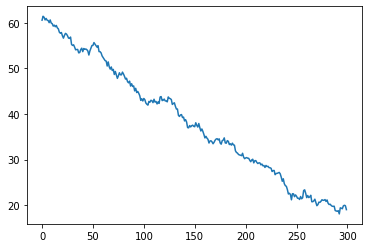

In [286]:
plt.plot(range(y.shape[0]), y[:, 39])

In [285]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
groups_memb = np.array([0] * 40 )
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector_test(300, y, x[:,0, np.newaxis], calc_cond=False)

T 300, n_stock 40
1 of 300 
2 of 300 
3 of 300 
4 of 300 
5 of 300 
6 of 300 
7 of 300 
8 of 300 
9 of 300 
10 of 300 
11 of 300 
12 of 300 
13 of 300 
14 of 300 
15 of 300 
16 of 300 
17 of 300 
18 of 300 
19 of 300 
20 of 300 
21 of 300 
22 of 300 
23 of 300 
24 of 300 
25 of 300 
26 of 300 
27 of 300 
28 of 300 
29 of 300 
30 of 300 
31 of 300 
32 of 300 
33 of 300 
34 of 300 
35 of 300 
36 of 300 
37 of 300 
38 of 300 
39 of 300 
40 of 300 
41 of 300 
42 of 300 
43 of 300 
44 of 300 
45 of 300 
46 of 300 
47 of 300 
48 of 300 
49 of 300 
50 of 300 
51 of 300 
52 of 300 
53 of 300 
54 of 300 
55 of 300 
56 of 300 
57 of 300 
58 of 300 
59 of 300 
60 of 300 
61 of 300 
62 of 300 
63 of 300 
64 of 300 
65 of 300 
66 of 300 
67 of 300 
68 of 300 
69 of 300 
70 of 300 
71 of 300 
72 of 300 
73 of 300 
74 of 300 
75 of 300 
76 of 300 
77 of 300 
78 of 300 
79 of 300 
80 of 300 
81 of 300 
82 of 300 
83 of 300 
84 of 300 
85 of 300 
86 of 300 
87 of 300 
88 of 300 
89 of 300 
90 of 300 
9

In [287]:
index = 0
print(f'a_x = {a_x[index]}, beta_i = {beta_i[index]}, v = {v[index]}, w = {w[0]}, eta = {eta[0]}')

a_x = 72.74078196107826, beta_i = 0.5566809005031842, v = 0.03481418287091843, w = 0.3, eta = -0.15


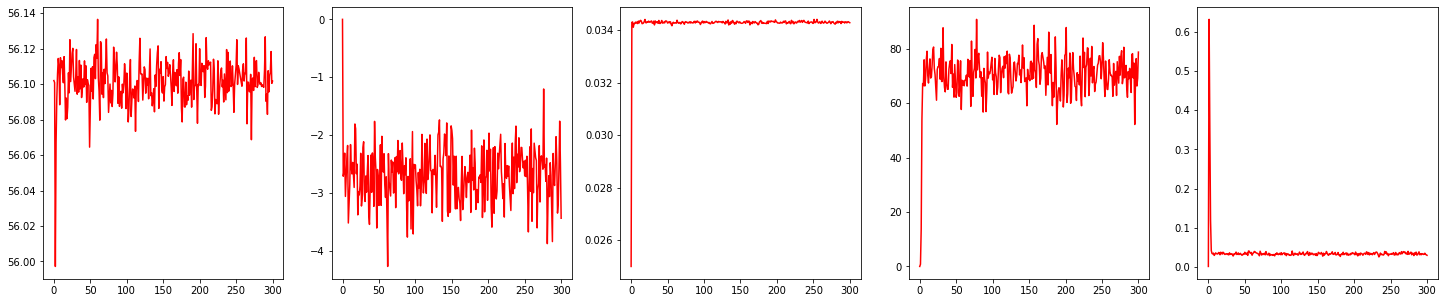

In [288]:
fig, ax = plt.subplots(1,5, figsize = (25,5))
ax[0].plot(range(A.shape[0]),A[:,0], color='r')
ax[1].plot(range(A.shape[0]),B[:,0], color='r')
ax[2].plot(range(A.shape[0]),beta[:,0], color='r')
ax[3].plot(range(A.shape[0]),w_g[:,0], color='r')
ax[4].plot(range(A.shape[0]),v_g[:,0], color='r')


In [265]:
smooth_state_draws_rnd[:, 0]

array([ 4.37021245e+00,  3.52971471e+02,  3.45902111e+02,  3.39320063e+02,
        3.39373624e+02,  3.21806198e+02,  3.17322177e+02,  3.06471029e+02,
        3.13511348e+02,  3.03807658e+02,  2.97562896e+02,  2.90930964e+02,
        2.89808669e+02,  2.80622035e+02,  2.72398751e+02,  2.86413616e+02,
        2.78579970e+02,  2.70629766e+02,  2.79077217e+02,  2.80289735e+02,
        2.82736842e+02,  2.81583861e+02,  2.71277033e+02,  2.61960474e+02,
        2.58303374e+02,  2.61126307e+02,  2.64084567e+02,  2.61464161e+02,
        2.64352416e+02,  2.64959843e+02,  2.67830216e+02,  2.70781542e+02,
        2.63541500e+02,  2.55663540e+02,  2.43022497e+02,  2.51796835e+02,
        2.56688085e+02,  2.66827104e+02,  2.66115320e+02,  2.70121413e+02,
        2.64342466e+02,  2.53108527e+02,  2.51561793e+02,  2.56110477e+02,
        2.52984953e+02,  2.54661120e+02,  2.57311702e+02,  2.55142993e+02,
        2.50692467e+02,  2.52650299e+02,  2.57474894e+02,  2.50866647e+02,
        2.67126937e+02,  

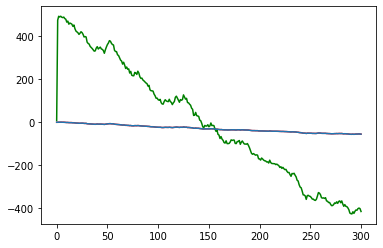

In [290]:
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((y.shape[1], 1))
F[:,0] = beta_i[:]

smooth_state_draws, R_cond = Gibbs.FFBS(y, np.array([[1]]), B = eta[0], W = np.array([[w[0]]]), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(1), init_c = np.diag([0.1]))
F_rnd = np.zeros((y.shape[1], 1))
i = 30
F_rnd[:,0] = beta[i,:]

smooth_state_draws_rnd, R_cond = Gibbs.FFBS(y, np.array([[1]]), B = B[i,0], W = np.array([[w_g[i,0]]]), F = F_rnd, A = A[i,:], V = np.diag(v_g[i,:]), init_x = np.zeros(1) * 100, init_c = np.diag([0.1]))
plt.plot(range(N+1), smooth_state_draws[:, 0], color = 'r')
plt.plot(range(N+1), smooth_state_draws_rnd[:, 0], color = 'g')
plt.plot(range(N+1), x[:, 0])


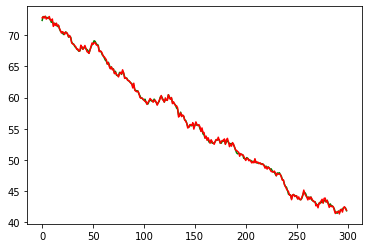

In [291]:
y_est = F_rnd[0,:]*(smooth_state_draws_rnd[1:, 0] - np.mean(smooth_state_draws_rnd[1:, 0])) + A[30,0]

plt.plot(range(y_est.shape[0]), y_est, color = 'g')
plt.plot(range(y.shape[0]), y[:,0], color = 'r')

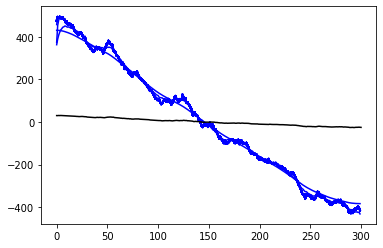

In [292]:
for i in range(states.shape[0]):
    plt.plot(range(states.shape[1]),states[i,:,0], color = 'b')

#plt.plot(range(x.shape[0]), states[0,:,0]/10, color = 'red')
plt.plot(range(x.shape[0]), x[:,0] - np.mean(x[:,0]), color = 'black')

# Test 2

This test is ill-specified. one-dimensional gibbs works

In [16]:
eta = np.array([-0.15, -0.12, -0.1, -0.07, -0.08])
w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])
beta_i = np.ones(40)*0.4 #np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.ones(40)*0.6 # np.random.uniform(0.01, 0.8, 40)
a_x = np.array(40 * [60.0])#np.random.uniform(50, 80, 40)
N = 50
v = np.ones(40)*0.03 # np.random.uniform(0.02, 0.08, 40)

yo = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)

x = np.zeros((N + 1, 5))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = w[0])
    x[i, 1] = x[i-1, 1] + eta[1] + np.random.normal(loc = 0, scale = w[1])

y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])


In [19]:
w[:2]

array([0.3, 0.5])

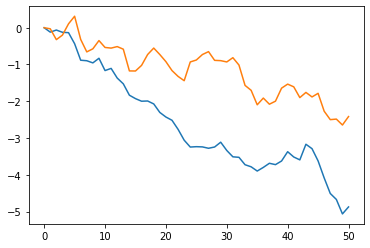

In [17]:
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((y.shape[1], 2))
F[:,0] = beta_i
F[:,1] = beta_s_i
state, state_cov, state_one_step, state_cov_one_step, y_est, R_cond = Gibbs.KalmanFilter(y, np.identity(2), B = eta[:2], W = np.diag(w[:2]), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(2), init_c = np.diag([1,1]))
k = 0
plt.plot(range(N+1), state[:, k])
plt.plot(range(N+1), x[:, k])

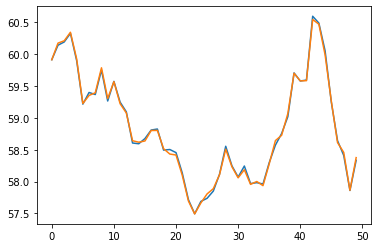

In [21]:
plt.plot(range(N), y[:,24])
plt.plot(range(N), y_est[:,24])

In [33]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
groups_memb = np.array([0] * 40 )
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector_test(1000, y,2350, calc_cond=False)

T 50, n_stock 40
1 of 1000 
2 of 1000 
3 of 1000 
4 of 1000 
5 of 1000 
6 of 1000 
7 of 1000 
8 of 1000 
9 of 1000 
10 of 1000 
11 of 1000 
12 of 1000 
13 of 1000 
14 of 1000 
15 of 1000 
16 of 1000 
17 of 1000 
18 of 1000 
19 of 1000 
20 of 1000 
21 of 1000 
22 of 1000 
23 of 1000 
24 of 1000 
25 of 1000 
26 of 1000 
27 of 1000 
28 of 1000 
29 of 1000 
30 of 1000 
31 of 1000 
32 of 1000 
33 of 1000 
34 of 1000 
35 of 1000 
36 of 1000 
37 of 1000 
38 of 1000 
39 of 1000 
40 of 1000 
41 of 1000 
42 of 1000 
43 of 1000 
44 of 1000 
45 of 1000 
46 of 1000 
47 of 1000 
48 of 1000 
49 of 1000 
50 of 1000 
51 of 1000 
52 of 1000 
53 of 1000 
54 of 1000 
55 of 1000 
56 of 1000 
57 of 1000 
58 of 1000 
59 of 1000 
60 of 1000 
61 of 1000 
62 of 1000 
63 of 1000 
64 of 1000 
65 of 1000 
66 of 1000 
67 of 1000 
68 of 1000 
69 of 1000 
70 of 1000 
71 of 1000 
72 of 1000 
73 of 1000 
74 of 1000 
75 of 1000 
76 of 1000 
77 of 1000 
78 of 1000 
79 of 1000 
80 of 1000 
81 of 1000 
82 of 1000 
83 of 10

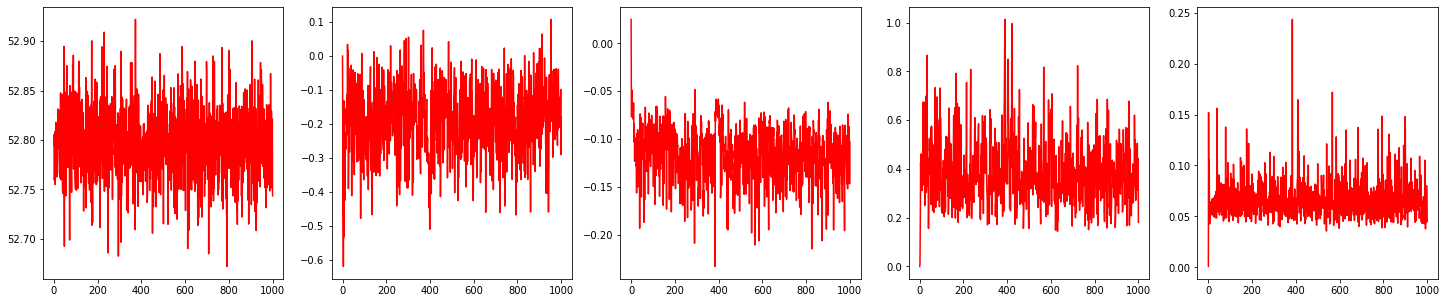

In [34]:
fig, ax = plt.subplots(1,5, figsize = (25,5))
ax[0].plot(range(A.shape[0]),A[:,0], color='r')
ax[1].plot(range(A.shape[0]),B[:,0], color='r')
ax[2].plot(range(A.shape[0]),beta[:,0], color='r')
ax[3].plot(range(A.shape[0]),w_g[:,0], color='r')
ax[4].plot(range(A.shape[0]),v_g[:,0], color='r')


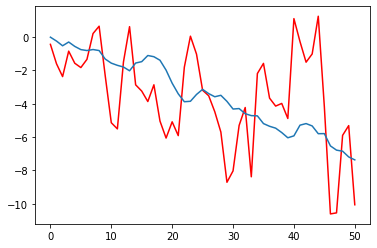

In [353]:
importlib.reload(sys.modules['Gibbs'])
F = np.zeros((y.shape[1], 2))
F[:,0] = beta_i
F[:,1] = beta_s_i
smooth_state_draws, R_cond = Gibbs.FFBS(y, np.identity(2), B = eta[:2], W = np.diag(w[:2]), F = F, A = a_x, V = np.diag(v), init_x = np.zeros(2), init_c = np.diag([0.1] * 2))
F_rnd = np.zeros((y.shape[1], 1))
i = 0
#F_rnd[:,0] = beta[i,:]

#smooth_state_draws_rnd, R_cond = Gibbs.FFBS(y, np.identity(2), B = B[i,0], W = np.diag(w_g[0]), F = F_rnd, A = A[i,:], V = np.diag(v_g[i,:]), init_x = np.zeros(2), init_c = np.diag([0.1] * 2))
plt.plot(range(N+1), smooth_state_draws[:, 0], color = 'r')
#plt.plot(range(N+1), smooth_state_draws_rnd[:, 0], color = 'g')
plt.plot(range(N+1), x[:, 0])


# Test 3

Let's test the Gibbs Sampler

In [165]:


#nr_groups = 4
#eta = np.array([-0.15, 1, -0.5, -2, 2])
#w = np.array([0.3, 0.5, 0.55, 0.55, 0.7])

nr_groups = 2
eta = np.array([-0.15, 0.2, -0.3])
w = np.array([0.3, 0.5, 0.55])

beta_i = np.random.uniform(0.01, 0.8, 40)
beta_s_i = np.random.uniform(0.2, 0.8, 40)
a_x = np.random.uniform(50, 80, 40)
N = 50
v = np.random.uniform(0.02, 0.08, 40)

#group_membership = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
group_membership = np.array([0] * 20 + [1] * 20 )


x = np.zeros((N + 1, nr_groups + 1))
# generate latent
for i in range(1, N+1):
    x[i, 0] = x[i-1, 0] + eta[0] + np.random.normal(loc = 0, scale = w[0])
    x[i, 1] = x[i-1, 1] + eta[1] + np.random.normal(loc = 0, scale = w[1])
    x[i, 2] = x[i-1, 2] + eta[2] + np.random.normal(loc = 0, scale = w[2])
    #x[i, 3] = x[i-1, 3] + eta[3] + np.random.normal(loc = 0, scale = w[3])
    #x[i, 4] = x[i-1, 4] + eta[4] + np.random.normal(loc = 0, scale = w[4])

y = np.zeros((N, 40))
for i in range(N):
    for j in range(40):
        # if j < 10:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        # elif j < 20:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])
        # elif j < 30:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,3] + np.random.normal(0, v[j])
        # elif j < 40:
        #     y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,4] + np.random.normal(0, v[j])

        if j < 30:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,1] + np.random.normal(0, v[j])
        else:
            y[i, j] = a_x[j] + beta_i[j]*x[i+1,0] + beta_s_i[j]*x[i+1,2] + np.random.normal(0, v[j])

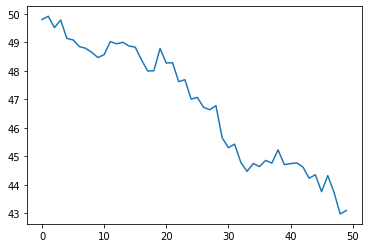

In [106]:
plt.plot(range(y.shape[0]), y[:,0])

In [107]:
betas = np.hstack((beta_i, beta_s_i))
index = np.array(range(40))
F = np.zeros((40,  5))
F[:,0] = beta_i[:40]
for j in range(4):
    F[index[yo == j],1 + j] = betas[40 + index[yo == j]]

In [9]:
betas[40 + index[yo == 0]]

array([0.29811029, 0.62524769, 0.78545736, 0.31110807, 0.2398609 ,
       0.25312692, 0.25338004, 0.77952246, 0.62975156, 0.28531228])

In [168]:
importlib.reload(sys.modules['Gibbs'])
# groups_memb = np.array([0] * 10 + [1] * 10 + [2] * 10 + [3] * 10)
w_g, v_g, beta, A, B, states, R_conds = Gibbs.lc_sector(1000, y, group_membership, calc_cond=False, regularize_S = False)

T 50, n_stock 40, n_groups 2
1 of 1000 
0.0 vs 0.0
2 of 1000 
0.0 vs 0.0
3 of 1000 
0.0 vs 0.0
4 of 1000 
0.0 vs 0.0
5 of 1000 
0.0 vs 0.0
6 of 1000 
0.0 vs 0.0
7 of 1000 
0.0 vs 0.0
8 of 1000 
0.0 vs 0.0
9 of 1000 
0.0 vs 0.0
10 of 1000 
0.0 vs 0.0
11 of 1000 
0.0 vs 0.0
12 of 1000 
0.0 vs 0.0
13 of 1000 
0.0 vs 0.0
14 of 1000 
0.0 vs 0.0
15 of 1000 
0.0 vs 0.0
16 of 1000 
0.0 vs 0.0
17 of 1000 
0.0 vs 0.0
18 of 1000 
0.0 vs 0.0
19 of 1000 
0.0 vs 0.0
20 of 1000 
0.0 vs 0.0
21 of 1000 
0.0 vs 0.0
22 of 1000 
0.0 vs 0.0
23 of 1000 
0.0 vs 0.0
24 of 1000 
0.0 vs 0.0
25 of 1000 
0.0 vs 0.0
26 of 1000 
0.0 vs 0.0
27 of 1000 
0.0 vs 0.0
28 of 1000 
0.0 vs 0.0
29 of 1000 
0.0 vs 0.0
30 of 1000 
0.0 vs 0.0
31 of 1000 
0.0 vs 0.0
32 of 1000 
0.0 vs 0.0
33 of 1000 
0.0 vs 0.0
34 of 1000 
0.0 vs 0.0
35 of 1000 
0.0 vs 0.0
36 of 1000 
0.0 vs 0.0
37 of 1000 
0.0 vs 0.0
38 of 1000 
0.0 vs 0.0
39 of 1000 
0.0 vs 0.0
40 of 1000 
0.0 vs 0.0
41 of 1000 
0.0 vs 0.0
42 of 1000 
0.0 vs 0.0
43 of 1000 
0.

a_x = 54.78493091040634, beta_i = 0.19306765580876617, v = 0.06721173871937369, w = 0.3, eta = -0.15


Text(0.5, 1.0, 'variance_x, x= 0')

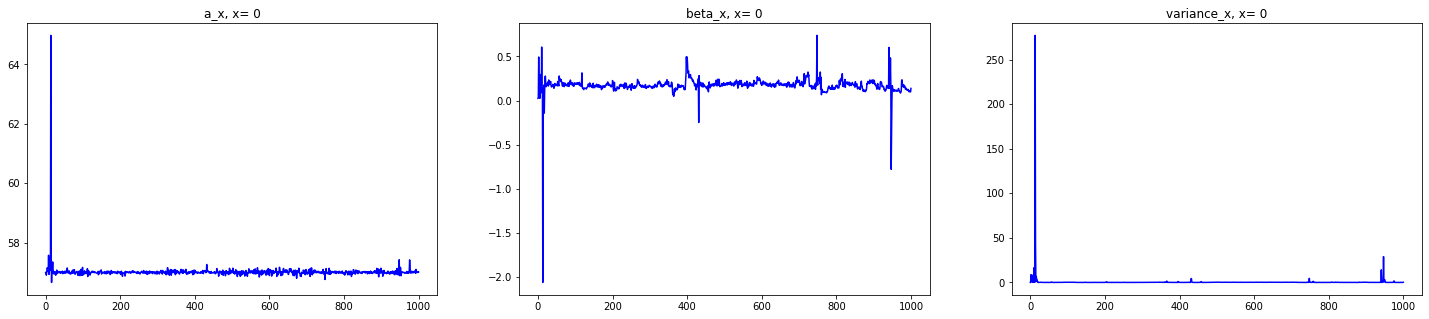

In [136]:
index = 0
print(f'a_x = {a_x[index]}, beta_i = {beta_i[index]}, v = {v[index]}, w = {w[0]}, eta = {eta[0]}')

fig, ax = plt.subplots(1,3, figsize = (25,5))
ax[0].plot(range(A.shape[0]),A[:,index], color='b')
ax[0].set_title(f'a_x, x= {index}')
ax[1].plot(range(A.shape[0]),beta[:,index], color='b')
ax[1].set_title(f'beta_x, x= {index}')
ax[2].plot(range(A.shape[0]),v_g[:,index], color='b')
ax[2].set_title(f'variance_x, x= {index}')
#ax[2].set_ylim(ymax = 0.15)


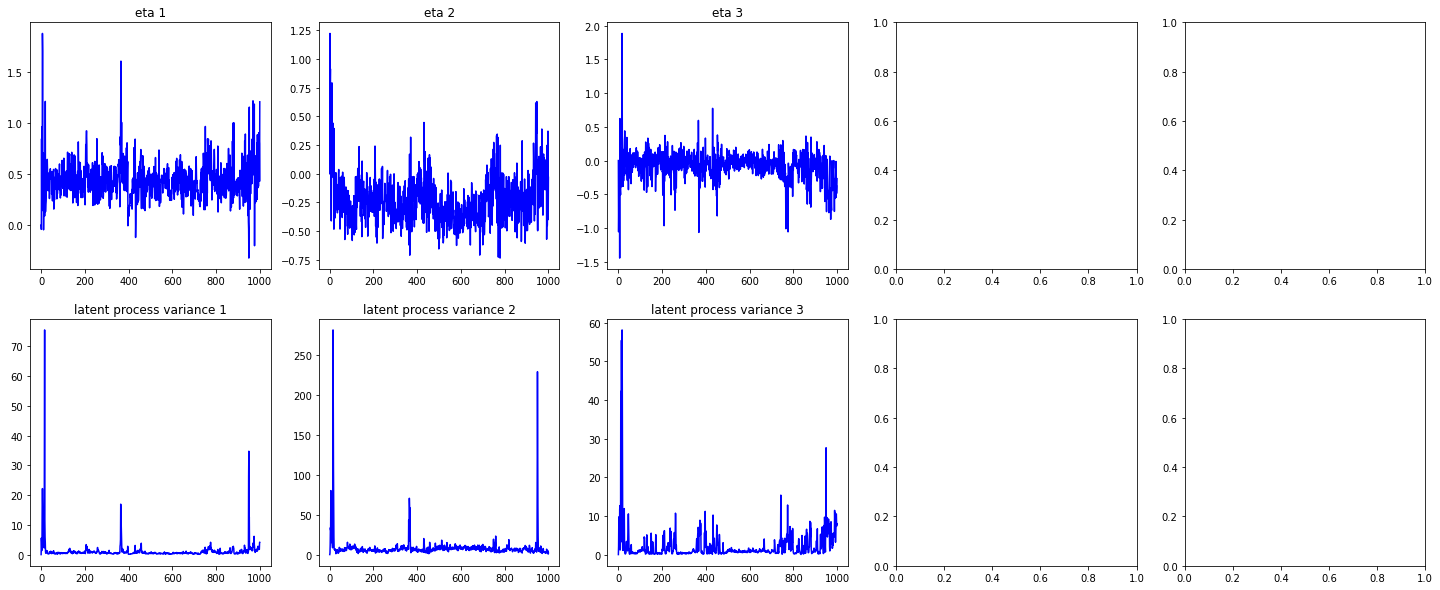

In [137]:
fig, ax = plt.subplots(2,5, figsize = (25,10))
for j in range(3):

        ax[0,j].plot(range(A.shape[0]),B[:,j], color='b')
        ax[0,j].set_title(f'eta {j+1}')
        ax[1,j].plot(range(A.shape[0]),w_g[:,j], color='b')
        ax[1,j].set_title(f'latent process variance {j+1}')


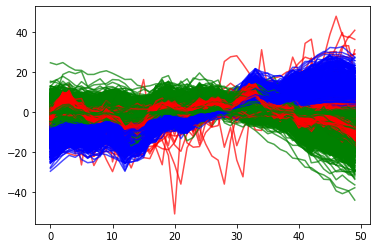

In [132]:
for i in range(states.shape[0]):
    plt.plot(range(states.shape[1]), states[i, :, 0], color = 'blue', alpha =0.7)
    plt.plot(range(states.shape[1]), states[i, :, 1], color = 'red', alpha =0.7)
    plt.plot(range(states.shape[1]), states[i, :, 2], color = 'green', alpha =0.7)